# Popularidade negativa do presidente

Este notebook é usado para atualizar os resultados de popularidade do modelo para o presidente da República quando uma nova nova observação é registrada na base de dados de pesquisas de opinião. Assim, nós conseguimos validadar a pesquisa rapidamente, ajustar o modelo, executar diagnósticos de validade do modelo e exportar os dados para o dashboard.

**Vez ou outra, nós também executamos algumas analises sobre as diferenças entre o modelo mais recente do anterior, antes de incluir uma nova observação.**

In [1]:
import sys
import os
try:
    import warnings                                                   
    warnings.filterwarnings('ignore')     
    import pandas as pd       
    import numpy as np
    import sqlite3
    import watermark
    import pymc3 as pm
    import xarray as xr
    import arviz as az
    import theano.tensor as aet
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import matplotlib.cbook as cbook
    from scipy.special import expit as logistic
    from IPython.display import display, HTML
    from dateutil.relativedelta import relativedelta

except ImportError:
    print("Error: missing one of the libraries..")
    sys.exit()

sys.path.append('../..')
    
from manager_db import *
from model_utils import *


# hide
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print(os.getcwd())
print(sys.argv[0])
print(os.path.dirname(os.path.realpath('__file__')))
print('Running on pymc3 v{}'.format(pm.__version__))
print('Running on arviz v{}'.format(az.__version__))

/Users/marcelino/dmarcelinobr/pollbase/dashboards/notebooks
/Users/marcelino/Library/Python/3.8/lib/python/site-packages/ipykernel_launcher.py
/Users/marcelino/dmarcelinobr/pollbase/dashboards/notebooks
Running on pymc3 v3.11.4
Running on arviz v0.11.2


## Carrega os dados

In [2]:
con = sqlite3.connect('../../pollingpoint.db')

aprovacao = pd.read_sql(""" SELECT 
data_fim, empresa, nome, positiva, regular, negativa, amostra, erro, presidente, modo 
FROM aprovacao WHERE tipo = "Avaliação do governo federal"
ORDER BY data_fim; """, con=con) 

# AND empresa = "Vox Populi"
con.close()

## Limpa e ajusta os dados

In [3]:
# Converte para datetime 
aprovacao["data_fim"] = pd.to_datetime(aprovacao["data_fim"])

# Index by field date
aprovacao.set_index("data_fim", inplace=True)

# sort by field date
aprovacao = aprovacao.sort_index(axis=0)

# Filter data to the time spam  
aprovacao = aprovacao.loc[aprovacao.index >= pd.to_datetime("1995-01-01")]

# Filter data to full term presidents
aprovacao = aprovacao.loc[aprovacao.presidente != "Dilma Rousseff II"]
aprovacao = aprovacao.loc[aprovacao.presidente != "Michel Temer"]

aprovacao["ano"] = aprovacao.index.year
aprovacao["mes"] = aprovacao.index.month
aprovacao["semana"] = aprovacao.index.week

# Correct a few typos in the dataset
# aprovacao["empresa"] = aprovacao["empresa"].replace("DEIA Big Data", "DEIA")
aprovacao["modo"] = aprovacao["modo"].replace("Online", "Internet")
aprovacao["modo"] = aprovacao["modo"].replace("FF", "Presencial")

# Convert approvals rates to proportion and compute total num approval
aprovacao[["positiva", "regular", "negativa"]] = (
    aprovacao[["positiva", "regular", "negativa"]].copy() / 100
)
# aprovacao = aprovacao.rename(columns={"positiva": "idx_aprova", "regular": "idx_neutro", "negativa": "idx_reprova"})

# Replace NA with 1000 interviews 
aprovacao["amostra"] = aprovacao["amostra"].replace(np.nan, 1000)
aprovacao["amostra"] = aprovacao["amostra"].astype("int") 
aprovacao["negativa_int"] = np.floor(aprovacao["amostra"] * aprovacao["negativa"]).astype("int")


# Reset the index
data = aprovacao.reset_index().rename(columns={"index": "data_fim"})

Vamos sumarizar rapidamente os dados que temos:

In [4]:
POLLSTERS = data["empresa"].sort_values().unique()
comment = f"""Base de pesquisas contendo {len(data)} pesquisas de intenção de votos para o primerio turno, realizadas entre {data["ano"].min()} e {data["ano"].max()}.
Existem {len(POLLSTERS)} empresas de pesquisa: {', '.join(list(POLLSTERS))}
"""
print(comment)

Base de pesquisas contendo 669 pesquisas de intenção de votos para o primerio turno, realizadas entre 1995 e 2021.
Existem 25 empresas de pesquisa: Atlas, Brasmarket, CNT, Datafolha, Futura, IDEIA Big Data, INCT/IDDC, Ibope, Ibpad, Instituto FSB, Instituto Methodus, Ipec, Ipespe, MDA, Offerwise, Orbis, Paraná, PoderData, Projeção, Quaest, Ranking Brasil, Real Time Big Data, Renascença, Sensus, Vox Populi



In [5]:
# display(HTML(data.to_html()))

In [6]:
# display(HTML(data.to_html()))
unicorn = ["#F20000", "#FF6700", "#FFF800", "#5AFF00", "#0092FF", "#7700FF"]

cariations = ["#FF5A00", "#FF005A", "#5AFF00", "#5A00FF", "#00FF5A", "#005AFF"]

## Validações

Precisamos verificar se não introduzimos nenhuma pesquisa com erro, em especial sobre o método ou modo de coleta, e outras validações visuais rápidas nos dados

In [7]:
pd.crosstab(data.empresa, data.modo, margins=True)

modo                CATI  IVR  Internet  Presencial  All
empresa                                                 
Atlas                  0    0        18           0   18
Brasmarket             1    0         0           0    1
CNT                    0    0         0           1    1
Datafolha              7    0         0         146  153
Futura                 1    0         0           0    1
IDEIA Big Data        10    0        53           0   63
INCT/IDDC              1    0         0           2    3
Ibope                  0    0         0         140  140
Ibpad                  7    0         0           0    7
Instituto FSB          8    0         0           0    8
Instituto Methodus     1    0         0           0    1
Ipec                   0    0         0           4    4
Ipespe                39    0         0           0   39
MDA                    1    0         0          19   20
Offerwise              0    0         7           0    7
Orbis                  0    3         0           0    3
Paraná                13    0         0           2   15
PoderData              0   42         0           0   42
Projeção               0    0         0           3    3
Quaest                 0    0         8           5   13
Ranking Brasil         9    0         0           0    9
Real Time Big Data     1    0         0           0    1
Renascença             1    0         0           0    1
Sensus                 0    0         0          72   72
Vox Populi             3    0         0          41   44
All                  103   45        86         435  669

In [8]:
pd.crosstab(data.empresa, data.presidente, margins=True)

presidente          Dilma Rousseff I  Fernando Henrique I  \
empresa                                                     
Atlas                              0                    0   
Brasmarket                         0                    0   
CNT                                1                    0   
Datafolha                         33                   19   
Futura                             0                    0   
IDEIA Big Data                     0                    0   
INCT/IDDC                          0                    0   
Ibope                             33                   16   
Ibpad                              0                    0   
Instituto FSB                      0                    0   
Instituto Methodus                 0                    0   
Ipec                               0                    0   
Ipespe                             0                    0   
MDA                               12                    0   
Offerwise                          0                    0   
Orbis                              0                    0   
Paraná                             0                    0   
PoderData                          0                    0   
Projeção                           1                    1   
Quaest                             0                    0   
Ranking Brasil                     0                    0   
Real Time Big Data                 0                    0   
Renascença                         0                    0   
Sensus                             2                    2   
Vox Populi                         1                   19   
All                               83                   57   

presidente          Fernando Henrique II  Jair Bolsonaro  Lula da Silva I  \
empresa                                                                     
Atlas                                  0              18                0   
Brasmarket                             0               1                0   
CNT                                    0               0                0   
Datafolha                             28              14               33   
Futura                                 0               1                0   
IDEIA Big Data                         0              63                0   
INCT/IDDC                              0               3                0   
Ibope                                 16               9               38   
Ibpad                                  0               7                0   
Instituto FSB                          0               8                0   
Instituto Methodus                     0               1                0   
Ipec                                   0               4                0   
Ipespe                                 0              39                0   
MDA                                    0               7                0   
Offerwise                              0               7                0   
Orbis                                  0               3                0   
Paraná                                 0              15                0   
PoderData                              0              42                0   
Projeção                               0               0                0   
Quaest                                 0              13                0   
Ranking Brasil                         0               9                0   
Real Time Big Data                     0               1                0   
Renascença                             0               1                0   
Sensus                                24               0               26   
Vox Populi                            18               6                0   
All                                   86             272               97   

presidente          Lula da Silva II  All  
empresa                                    
Atlas                              0   18  
Br

In [9]:
pd.crosstab(data.ano, data.presidente, margins=True)

presidente  Dilma Rousseff I  Fernando Henrique I  Fernando Henrique II  \
ano                                                                       
1995                       0                   19                     0   
1996                       0                    7                     0   
1997                       0                   11                     0   
1998                       0                   20                     0   
1999                       0                    0                    20   
2000                       0                    0                    19   
2001                       0                    0                    20   
2002                       0                    0                    27   
2003                       0                    0                     0   
2004                       0                    0                     0   
2005                       0                    0                     0   
2006                       0                    0                     0   
2007                       0                    0                     0   
2008                       0                    0                     0   
2009                       0                    0                     0   
2010                       0                    0                     0   
2011                      10                    0                     0   
2012                       9                    0                     0   
2013                      15                    0                     0   
2014                      49                    0                     0   
2019                       0                    0                     0   
2020                       0                    0                     0   
2021                       0                    0                     0   
All                       83                   57                    86   

presidente  Jair Bolsonaro  Lula da Silva I  Lula da Silva II  All  
ano                                                                 
1995                     0                0                 0   19  
1996                     0                0                 0    7  
1997                     0                0                 0   11  
1998                     0                0                 0   20  
1999                     0                0                 0   20  
2000                     0                0                 0   19  
2001                     0                0                 0   20  
2002                     0                0                 0   27  
2003                     0               18                 0   18  
2004                     0               15                 0   15  
2005                     0               21                 0   21  
2006                     0               43                 0   43  
2007                     0                0                12   12  
2008                     0                0                15   15  
2009                     0                0                25   25  
2010                     0                0                22   22  
2011                     0                0                 0   10  
2012                     0                0                 0    9  
2013                     0                0                 0   15  
2014                     0                0                 0   49  
2019                    80                0                 0   80  
2020                   111                0                 0  111  
2021                    81                0                 0   81  
All                    272               97                74  669

In [10]:
pd.crosstab(data.ano, data.mes, margins=True)

mes    1   2   3   4   5   6   7   8   9  10  11  12  All
ano                                                      
1995   1   2   4   1   2   2   2   1   2   0   1   1   19
1996   0   1   0   0   1   1   0   1   1   0   0   2    7
1997   0   0   2   0   2   1   0   1   2   1   0   2   11
1998   2   0   2   2   3   2   3   2   2   0   0   2   20
1999   1   1   3   1   2   1   2   1   3   1   2   2   20
2000   1   2   2   1   2   2   1   1   1   2   1   3   19
2001   1   1   2   1   2   3   1   1   3   1   1   3   20
2002   1   2   3   2   3   2   3   3   4   3   0   1   27
2003   1   0   2   3   1   2   1   2   1   2   0   3   18
2004   0   1   4   0   1   2   0   2   2   0   1   2   15
2005   0   1   0   1   2   5   2   3   2   2   1   2   21
2006   1   3   2   2   3   1   4   8  10   7   0   2   43
2007   1   0   1   3   0   1   1   1   1   1   1   1   12
2008   0   1   3   1   0   2   0   0   4   0   1   3   15
2009   1   0   4   1   2   4   1   3   6   0   2   1   25
2010   1   1   1   1   2   0   2   3   5   4   1   1   22
2011   1   0   2   0   0   1   1   3   1   0   0   1   10
2012   1   0   1   1   0   1   1   1   1   0   0   2    9
2013   0   0   2   0   0   4   2   1   2   1   2   1   15
2014   0   2   1   3   2   3   3   6  14  13   0   2   49
2019   5   5   7   8   5   5   6  10   6   7   7   9   80
2020   5   7  10  18  17  11   6   9   7   8   7   6  111
2021   8   8  10   4   9   8  12   5  10   4   3   0   81
All   32  38  68  54  61  64  54  68  90  57  31  52  669

Agora vamos plotar alguns resultados de pesquisas sobre o governo de Jair Bolsonaro, destacando os últimos cinco pontos de dados:

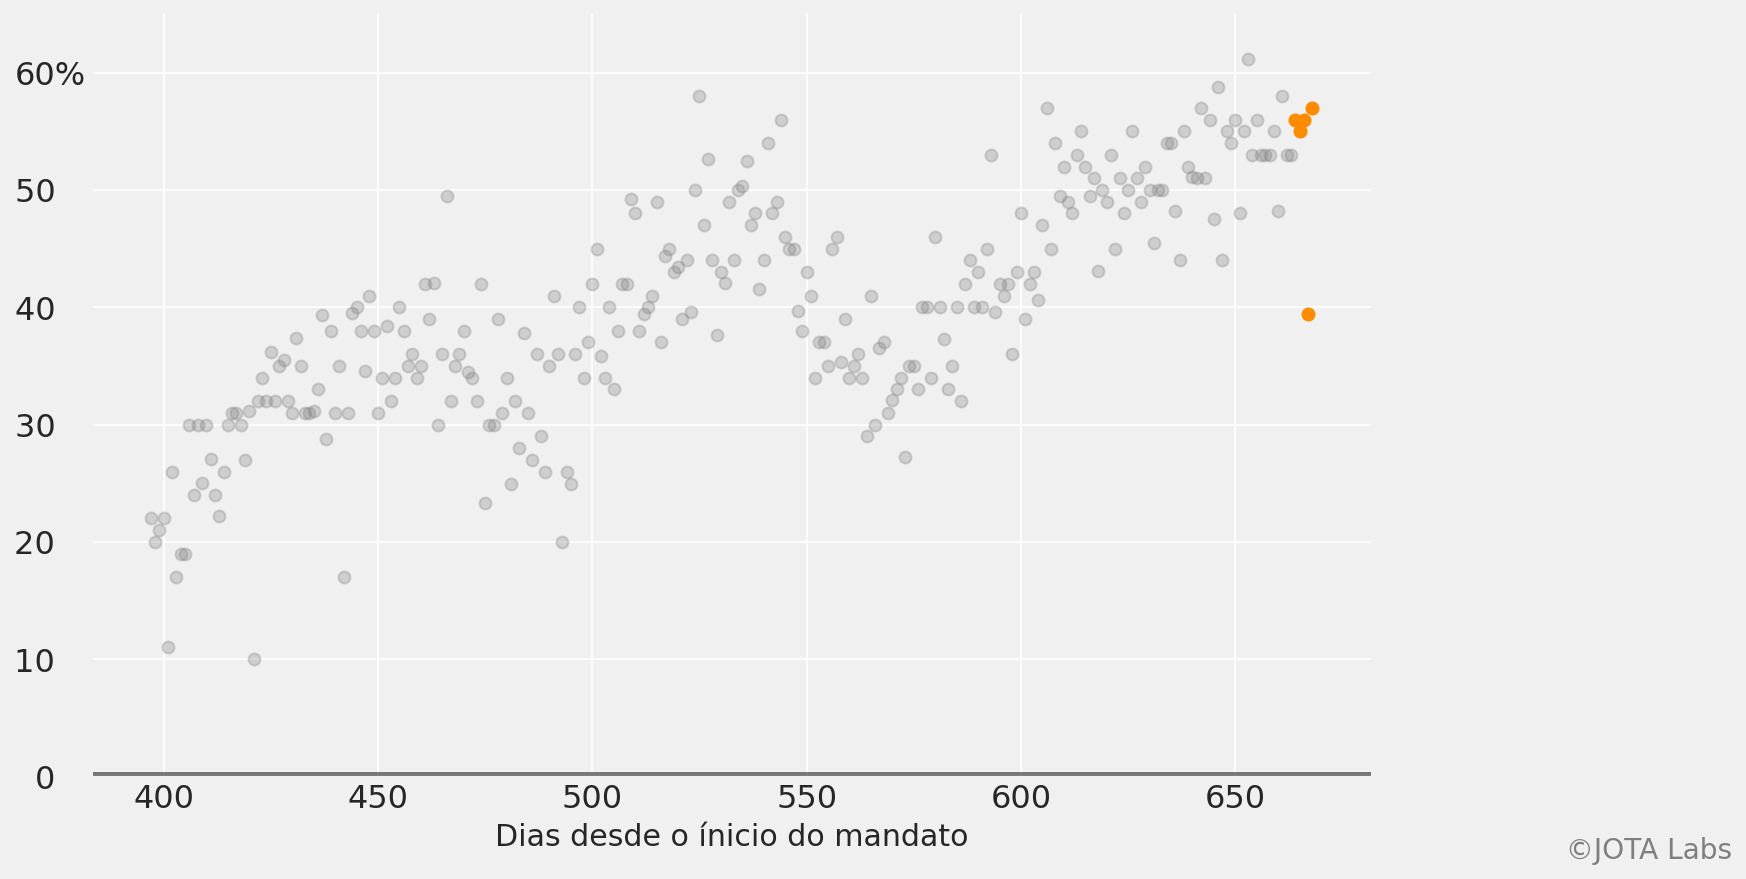

In [11]:
aprovacao = data.loc[data.presidente == "Jair Bolsonaro"]["negativa"].values
dias = data.loc[data.presidente == "Jair Bolsonaro"].index

fig, ax = plt.subplots(figsize=(12, 6), facecolor="#f0f0f0")
ax.set_facecolor("#f0f0f0")
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.plot(dias[:-5], 100*aprovacao[:-5], "o", color="grey", alpha=0.3)
ax.plot(dias[-5:], 100*aprovacao[-5:], "o", color="darkorange")
ax.set_yticklabels(labels = ['0   ', '10   ', '20   ', '30   ', '40   ', '50   ', '60%'])
ax.set_ylim(0, 65)
# ax.set_ylabel("Avaliação positiva")
ax.set_xlabel("Dias desde o ínicio do mandato")
# Generate a bolded horizontal line at y = 0
ax.axhline(y = 0, color = 'black', linewidth = 4, alpha = .5)
# The signature bar
ax.text(x = 725, y = -7, s = ' ©JOTA Labs', fontsize = 14, color = '#7F7F7F', backgroundcolor = '#f0f0f0');
# Adding a title and a subtitle
# ax.text(x = 400, y = 70, s = "Pesquisas podem apresentar superdispersão - mesmo quando coletadas no mesmo período", fontsize = 22, weight = 'bold', alpha = .75)

## Modelo

Vamos preparar os dados e estrutura da informação para o modelo escolhido:

In [12]:
empresa_por_metodo_id, empresa_por_metodo = data.set_index(
    ["empresa", "modo"]
).index.factorize(sort=True)

mes_id = np.hstack(
    [
        pd.Categorical(
            data[data.presidente == presidente].data_fim.dt.to_period("M")
        ).codes
        for presidente in data.presidente.unique()
    ]
)

meses = np.arange(max(mes_id) + 1)

data["mes_id"] = mes_id

presidente_id, presidentes = data["presidente"].factorize(sort=False)

COORDS = {
    "empresa_por_metodo": empresa_por_metodo,
    "mes": meses,
    "mes_menos_origem": meses[1:],
    "presidente": presidentes,
    "observacao": data.set_index(["empresa", "data_fim"]).index,
}

In [13]:
print(COORDS)

{'empresa_por_metodo': MultiIndex([(             'Atlas',   'Internet'),
            (        'Brasmarket',       'CATI'),
            (               'CNT', 'Presencial'),
            (         'Datafolha',       'CATI'),
            (         'Datafolha', 'Presencial'),
            (            'Futura',       'CATI'),
            (    'IDEIA Big Data',       'CATI'),
            (    'IDEIA Big Data',   'Internet'),
            (         'INCT/IDDC',       'CATI'),
            (         'INCT/IDDC', 'Presencial'),
            (             'Ibope', 'Presencial'),
            (             'Ibpad',       'CATI'),
            (     'Instituto FSB',       'CATI'),
            ('Instituto Methodus',       'CATI'),
            (              'Ipec', 'Presencial'),
            (            'Ipespe',       'CATI'),
            (               'MDA',       'CATI'),
            (               'MDA', 'Presencial'),
            (         'Offerwise',   'Internet'),
            (             '

Em seguida vamos definir a distribuição `ZeroSumNormal` que vamos usar para a versão final do modelo.
Qual é a racionalidade aqui? Vamos imaginar que X e Y são variáveis aleatórias e que são normalmente distribuídas (e portanto conjuntamente), então a soma dessas duas quantidades também serão distribuições normais.

Além disso, imagine que X, Y, W, Z tenham os seguintes desvios (-0.5, +1.2, +0.1, -0.8). Todos os elementos somam zero ou muito próximo disso e cada elemento em particular é muito pequeno, menor que 2% ou 3% que é a margem de erro geralmente estimada pelas empresas de pesquisa.


In [14]:
from typing import *


def ZeroSumNormal(
    name: str,
    sigma: float = 1.0,
    *,
    dims: Union[str, Tuple[str]],
    model: Optional[pm.Model] = None,
):
    """
    Multivariate normal, such that sum(x, axis=-1) = 0.

    Parameters

    name: str
        String name representation of the PyMC variable.
    sigma: float, defaults to 1
        Scale for the Normal distribution. If none is provided, a standard Normal is used.
    dims: Union[str, Tuple[str]]
        Dimension names for the shape of the distribution.
        See https://docs.pymc.io/pymc-examples/examples/pymc3_howto/data_container.html for an example.
    model: Optional[pm.Model], defaults to None
        PyMC model instance. If ``None``, a model instance is created.

    Notes
    ----------
    Contributed by Adrian Seyboldt (@aseyboldt).
    """
    if isinstance(dims, str):
        dims = (dims,)

    model = pm.modelcontext(model)
    *dims_pre, dim = dims
    dim_trunc = f"{dim}_truncado_"
    (shape,) = model.shape_from_dims((dim,))
    assert shape >= 1

    model.add_coords({f"{dim}_truncado_": pd.RangeIndex(shape - 1)})
    raw = pm.Normal(
        f"{name}_truncado_", dims=tuple(dims_pre) + (dim_trunc,), sigma=sigma
    )
    Q = make_sum_zero_hh(shape)
    draws = aet.dot(raw, Q[:, 1:].T)

    return pm.Deterministic(name, draws, dims=dims)


def make_sum_zero_hh(N: int) -> np.ndarray:
    """
    Build a householder transformation matrix that maps e_1 to a vector of all 1s.
    """
    e_1 = np.zeros(N)
    e_1[0] = 1
    a = np.ones(N)
    a /= np.sqrt(a @ a)
    v = a + e_1
    v /= np.sqrt(v @ v)
    return np.eye(N) - 2 * np.outer(v, v)

E finalmente o modelo escolhido:

In [15]:
with pm.Model(coords=COORDS) as hierarchical_monthly_popularity:

    baseline = pm.Normal("baseline")
    efeito_presidente = ZeroSumNormal("efeito_presidente", sigma=0.15, dims="presidente")
    efeito_empresa = ZeroSumNormal("efeito_empresa", sigma=0.15, dims="empresa_por_metodo")
    efeito_mensal = ZeroSumNormal("efeito_mensal", sigma=0.15, dims="mes")

    # need the cumsum parametrization to properly control the init of the GRW
    rw_inicial = aet.zeros(shape=(len(COORDS["presidente"]), 1))
    rw_variacoes = pm.Normal(
        "rw_choques",
        dims=("presidente", "mes_menos_origem"),
    )
    rw_bruto = aet.cumsum(aet.concatenate([rw_inicial, rw_variacoes], axis=-1), axis=-1)
    sd = pm.HalfNormal("contracoes_pop", 0.2)
    
    efeito_mes_presidente = pm.Deterministic(
        "efeito_mes_presidente", rw_bruto * sd, dims=("presidente", "mes")
    )

    popularidade = pm.math.invlogit(
        baseline
        + efeito_presidente[presidente_id]
        + efeito_mensal[mes_id]
        + efeito_mes_presidente[presidente_id, mes_id]
        + efeito_empresa[empresa_por_metodo_id]
    )

    # overdispersion parameter
    theta = pm.Exponential("theta_dispersao", 1.0) + 10.0

    aprovacao_latente = pm.BetaBinomial(
        "aprovacao_latente",
        alpha=popularidade * theta,
        beta=(1.0 - popularidade) * theta,
        n=data["amostra"],
        observed=data["negativa_int"],
        dims="observacao",
    )

In [16]:
with hierarchical_monthly_popularity:
    aprovacao_trace = pm.sample(tune=1000, draws=2000, chains=4, return_inferencedata=True, target_accept=0.95)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_dispersao, contracoes_pop, rw_choques, efeito_mensal_truncado_, efeito_empresa_truncado_, efeito_presidente_truncado_, baseline]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 499 seconds.


0, dim: observacao, 669 =? 669


Vamos olhar os dados das simulações para ver se são plausíveis ou se precisam de algum ajuste nos parâmetros:

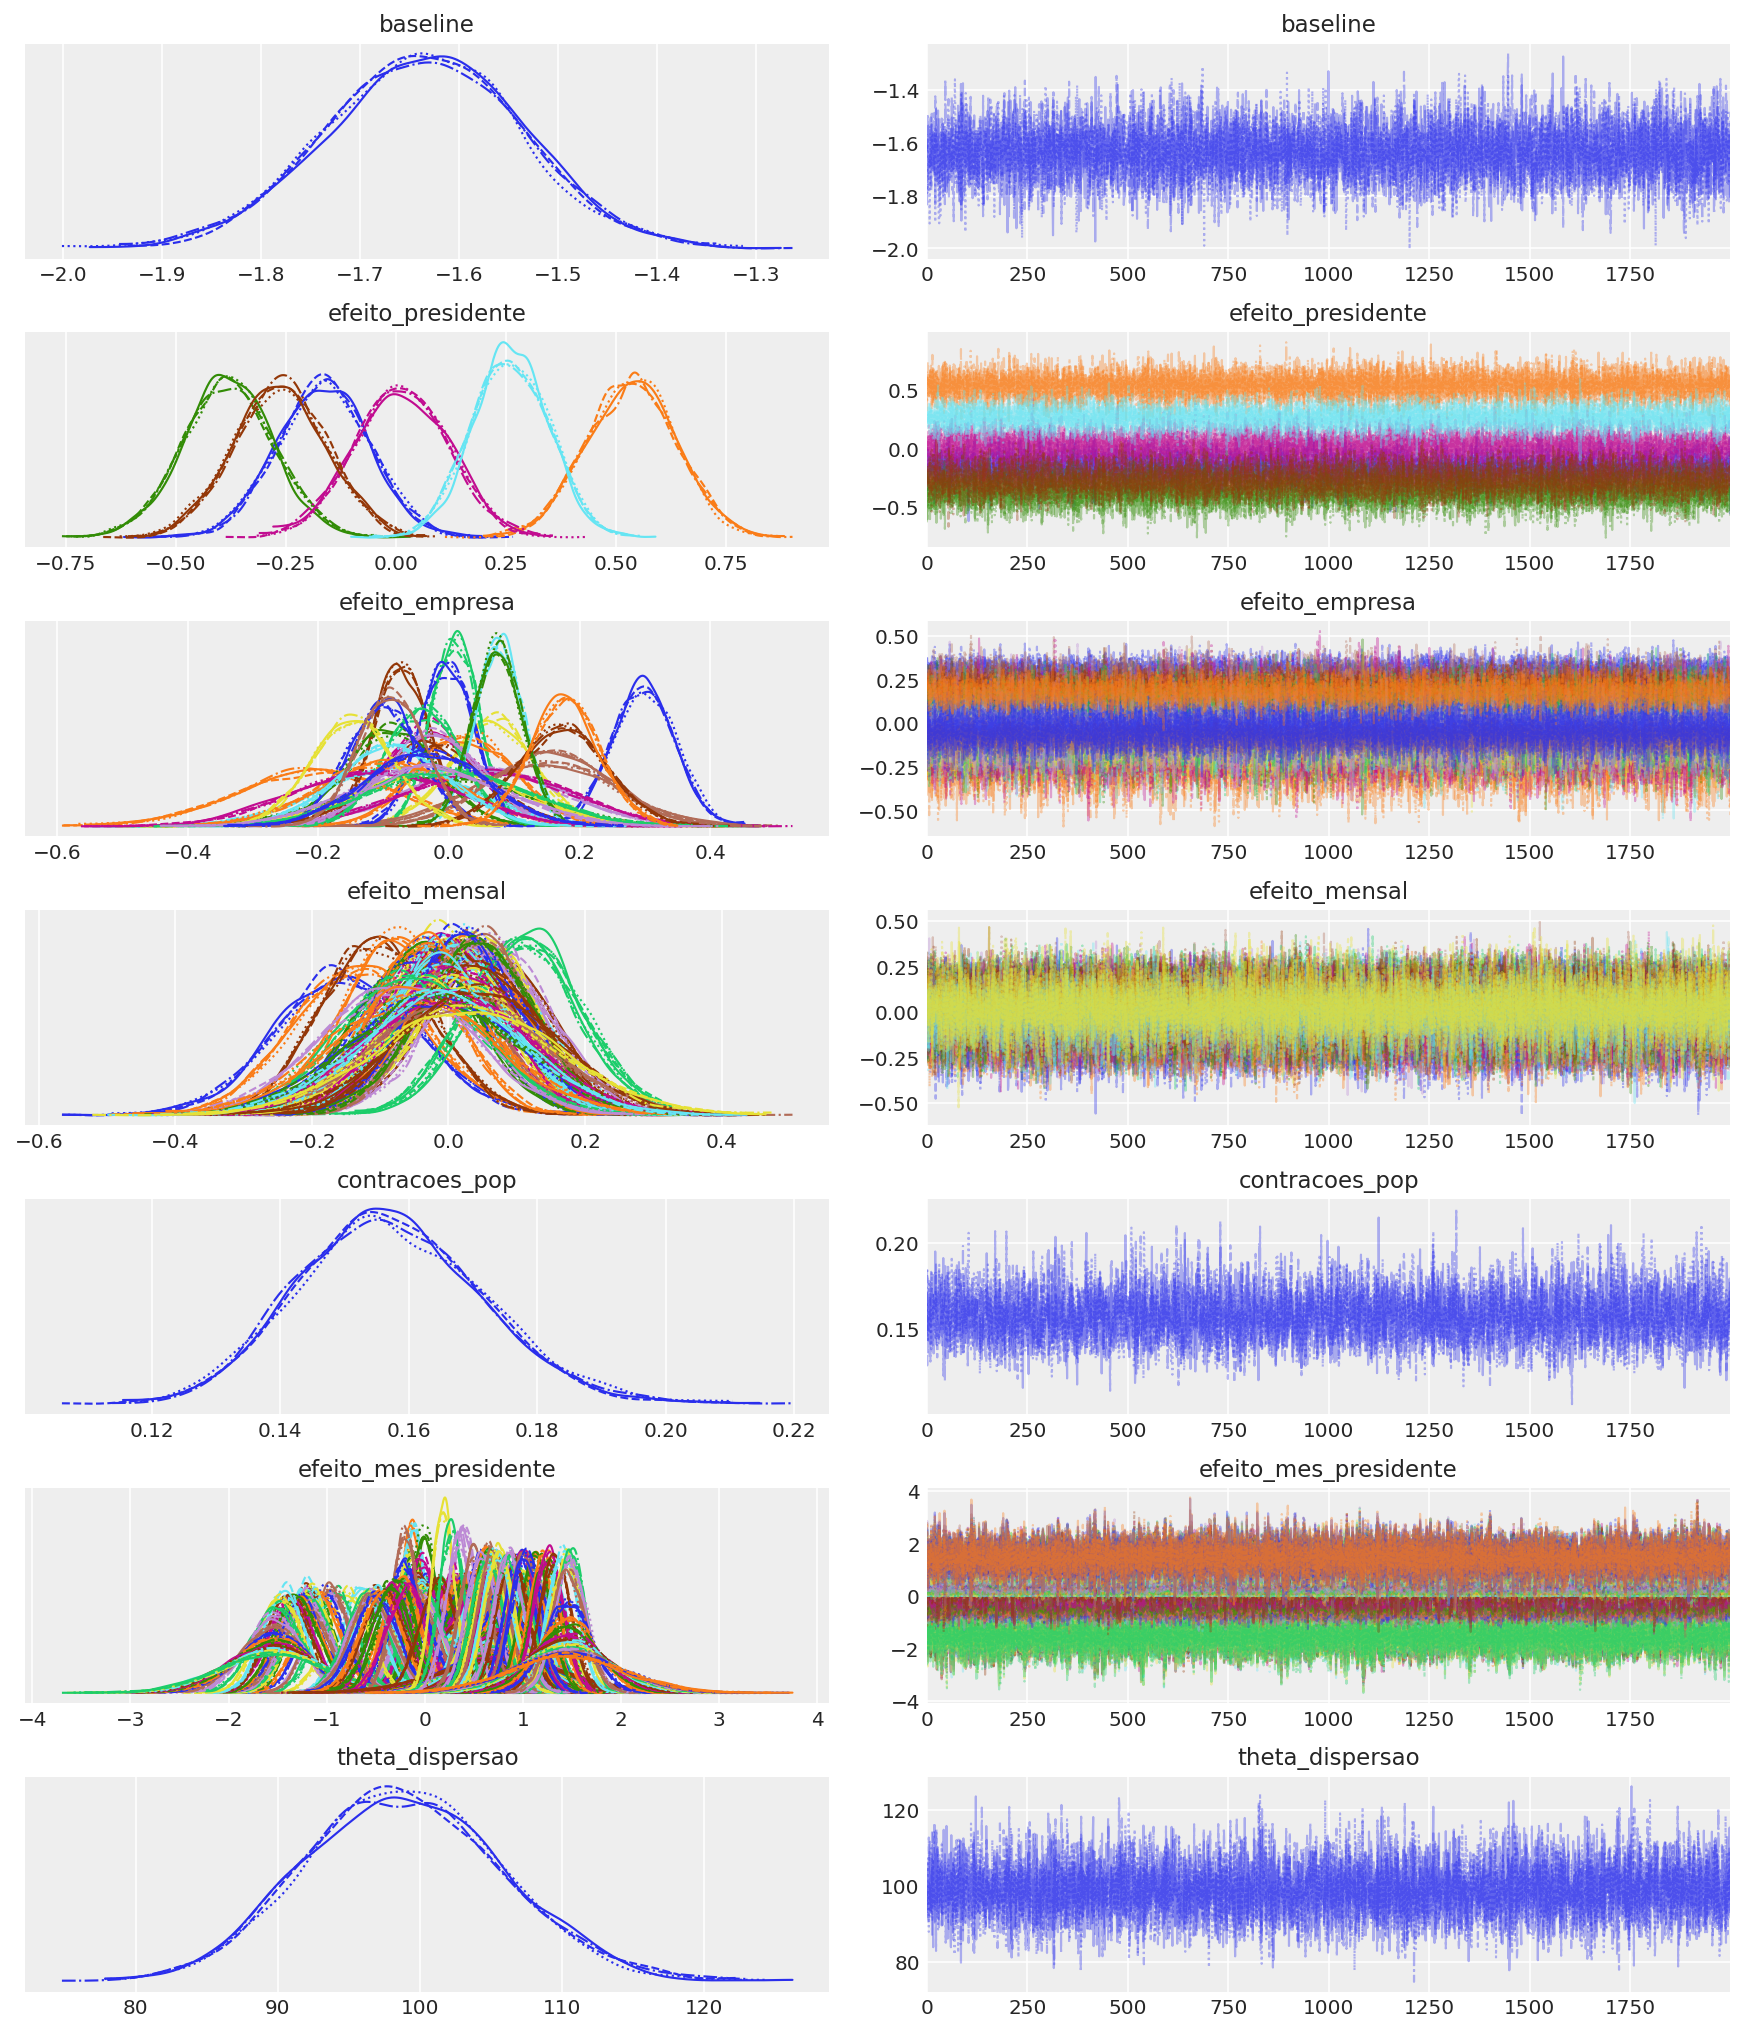

In [17]:
traces = az.plot_trace(
    aprovacao_trace,
    var_names=["~truncado", "~rw_choques"],
    filter_vars="regex",
    compact=True,
);

fig = traces.ravel()[0].figure
fig.savefig("popularidade_negativa_trace.png")

Veja o número de amostras efetivas e $\hat{R}$

In [18]:
az.summary(
    aprovacao_trace,
    round_to=2,
    var_names=["~truncado", "~rw_choques"],
    filter_vars="regex",
)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
baseline                     -1.64  0.10   -1.83    -1.45       0.00     0.00   
efeito_presidente[0]         -0.16  0.10   -0.37     0.02       0.00     0.00   
efeito_presidente[1]          0.54  0.10    0.34     0.72       0.00     0.00   
efeito_presidente[2]         -0.38  0.10   -0.58    -0.19       0.00     0.00   
efeito_presidente[3]          0.01  0.11   -0.19     0.21       0.00     0.00   
...                            ...   ...     ...      ...        ...      ...   
efeito_mes_presidente[5,43]   1.45  0.51    0.47     2.38       0.00     0.00   
efeito_mes_presidente[5,44]   1.45  0.53    0.46     2.48       0.00     0.00   
efeito_mes_presidente[5,45]   1.45  0.56    0.40     2.50       0.00     0.00   
efeito_mes_presidente[5,46]   1.45  0.58    0.36     2.54       0.00     0.00   
theta_dispersao              98.89  6.99   85.96   111.83       0.07     0.05   

                             ess_bulk  ess_tail  r_hat  
baseline                      7996.23   6198.68    1.0  
efeito_presidente[0]         14913.68   6248.26    1.0  
efeito_presidente[1]         15304.65   5663.74    1.0  
efeito_presidente[2]         19173.84   6166.27    1.0  
efeito_presidente[3]         17299.55   5904.57    1.0  
...                               ...       ...    ...  
efeito_mes_presidente[5,43]  15655.76   5561.12    1.0  
efeito_mes_presidente[5,44]  16348.59   5651.95    1.0  
efeito_mes_presidente[5,45]  16811.72   5246.77    1.0  
efeito_mes_presidente[5,46]  17462.74   5609.77    1.0  
theta_dispersao               9356.45   6668.39    1.0  

[370 rows x 9 columns]

## Estimativas a partir da Posterior
Vamos analisar os viéses calculados. Pra mim parecem bastante razoáveis:


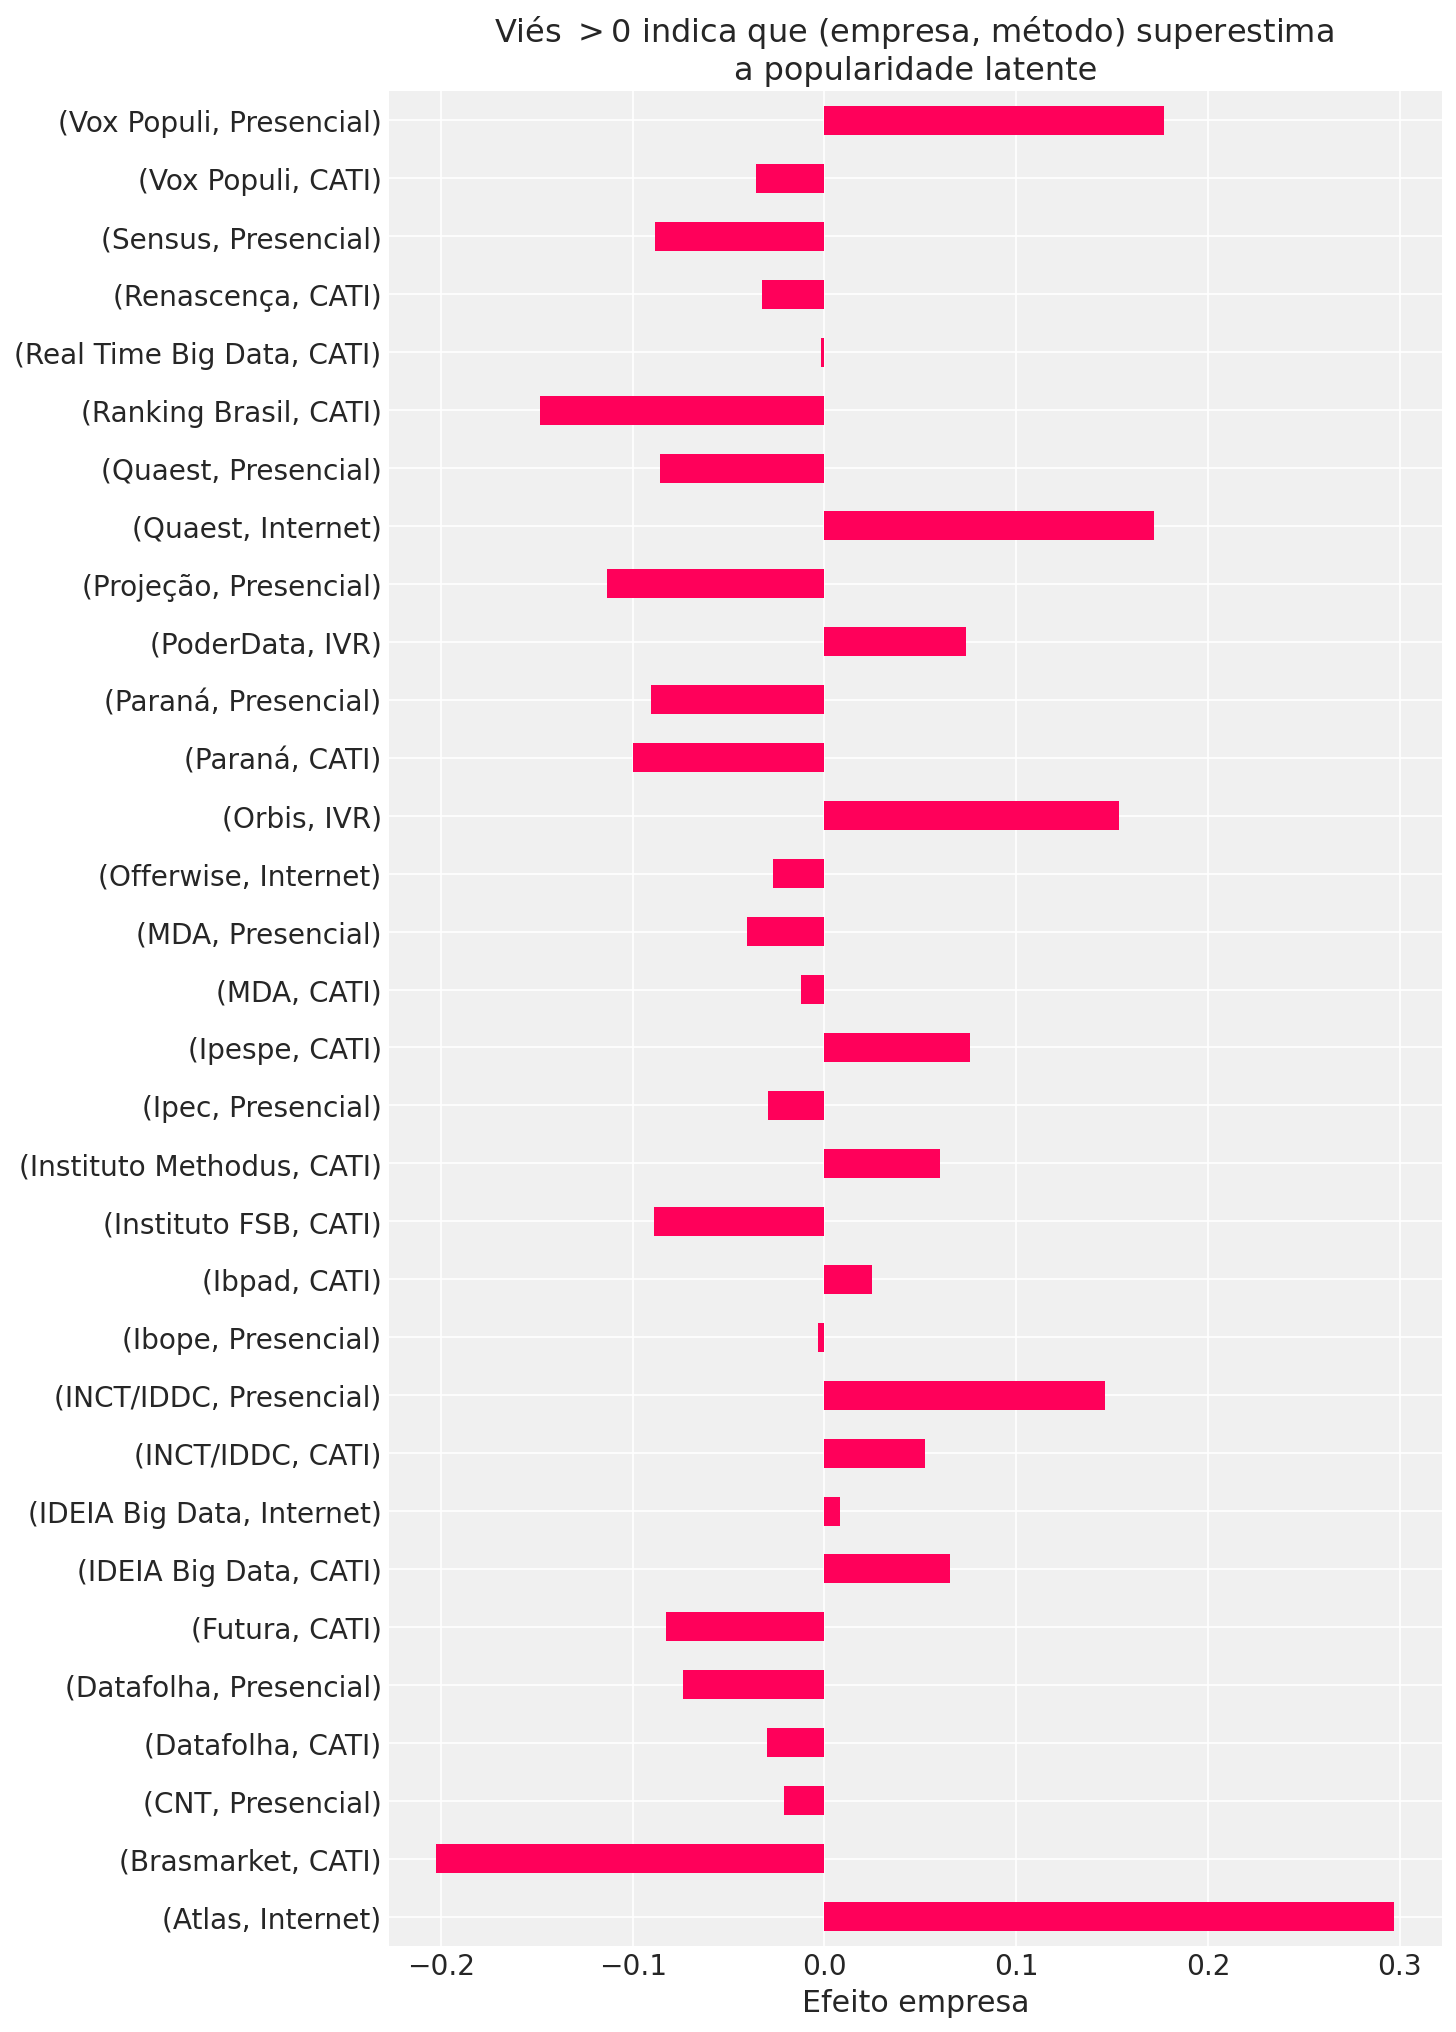

In [19]:

media_efeito_empresa = (
    aprovacao_trace.posterior["efeito_empresa"].mean(("chain", "draw")).to_dataframe()
)



ax = media_efeito_empresa.plot.barh(figsize=(10, 14), color=cariations[1], align='center', legend=None)
ax.set_facecolor("#f0f0f0")
ax.set_xlabel("Efeito empresa")
ax.set_ylabel(None)
ax.set_title("Viés $>0$ indica que (empresa, método) superestima \na popularidade latente");

# ax.figure.savefig("vies_empresas_metodo.png", bbox_inches = 'tight', facecolor=fig.get_facecolor(), edgecolor='none', transparent=False, pad_inches = 0)



In [20]:
media_efeito_empresa.round(2)

efeito_empresa
empresa_por_metodo_level_0 empresa_por_metodo_level_1                
Atlas                      Internet                              0.30
Brasmarket                 CATI                                 -0.20
CNT                        Presencial                           -0.02
Datafolha                  CATI                                 -0.03
                           Presencial                           -0.07
Futura                     CATI                                 -0.08
IDEIA Big Data             CATI                                  0.07
                           Internet                              0.01
INCT/IDDC                  CATI                                  0.05
                           Presencial                            0.15
Ibope                      Presencial                           -0.00
Ibpad                      CATI                                  0.02
Instituto FSB              CATI                                 -0.09
Instituto Methodus         CATI                                  0.06
Ipec                       Presencial                           -0.03
Ipespe                     CATI                                  0.08
MDA                        CATI                                 -0.01
                           Presencial                           -0.04
Offerwise                  Internet                             -0.03
Orbis                      IVR                                   0.15
Paraná                     CATI                                 -0.10
                           Presencial                           -0.09
PoderData                  IVR                                   0.07
Projeção                   Presencial                           -0.11
Quaest                     Internet                              0.17
                           Presencial                           -0.09
Ranking Brasil             CATI                                 -0.15
Real Time Big Data         CATI                                 -0.00
Renascença                 CATI                                 -0.03
Sensus                     Presencial                           -0.09
Vox Populi                 CATI                                 -0.04
                           Presencial                            0.18

In [21]:

data = data.merge(
    data.groupby(["ano", "mes"])["negativa"].mean().reset_index(),
    on=["ano", "mes"],
    suffixes=["", "_med"],
)


obs_media = data.groupby(["presidente", "mes_id"]).last()["negativa_med"].unstack().T

# display(HTML(obs_media.to_html()))

In [22]:
aprovacao_trace.posterior.sel

<bound method Dataset.sel of <xarray.Dataset>
Dimensions:                       (chain: 4, draw: 2000, presidente_truncado_: 5, empresa_por_metodo_truncado_: 31, mes_truncado_: 46, presidente: 6, mes_menos_origem: 46, empresa_por_metodo: 32, mes: 47)
Coordinates:
  * chain                         (chain) int64 0 1 2 3
  * draw                          (draw) int64 0 1 2 3 4 ... 1996 1997 1998 1999
  * presidente_truncado_          (presidente_truncado_) int64 0 1 2 3 4
  * empresa_por_metodo_truncado_  (empresa_por_metodo_truncado_) int64 0 ... 30
  * mes_truncado_                 (mes_truncado_) int64 0 1 2 3 ... 42 43 44 45
  * presidente                    (presidente) object 'Fernando Henrique I' ....
  * mes_menos_origem              (mes_menos_origem) int64 1 2 3 4 ... 44 45 46
  * empresa_por_metodo            (empresa_por_metodo) MultiIndex
  - empresa_por_metodo_level_0    (empresa_por_metodo) object 'Atlas' ... 'Vo...
  - empresa_por_metodo_level_1    (empresa_por_metodo) obj

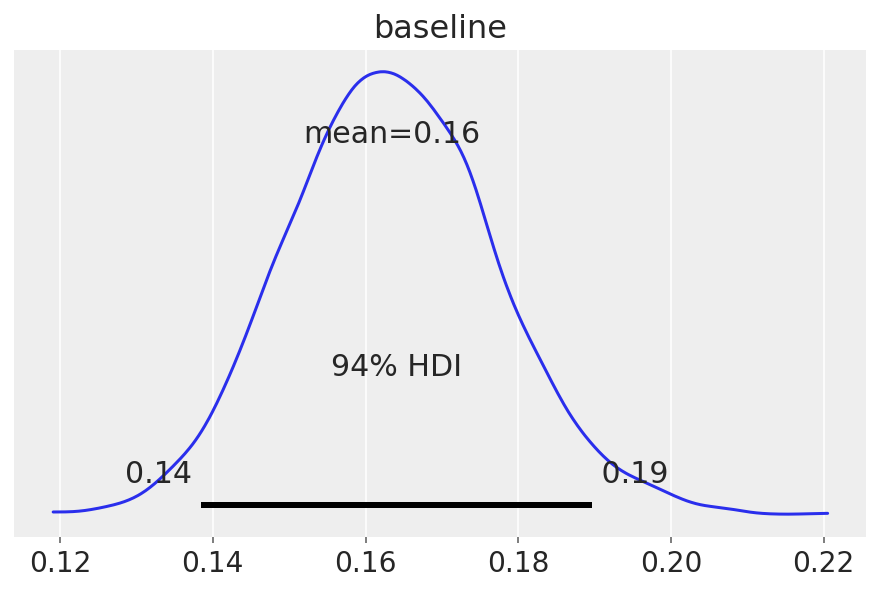

In [23]:
az.plot_posterior(logistic(aprovacao_trace.posterior["baseline"]));

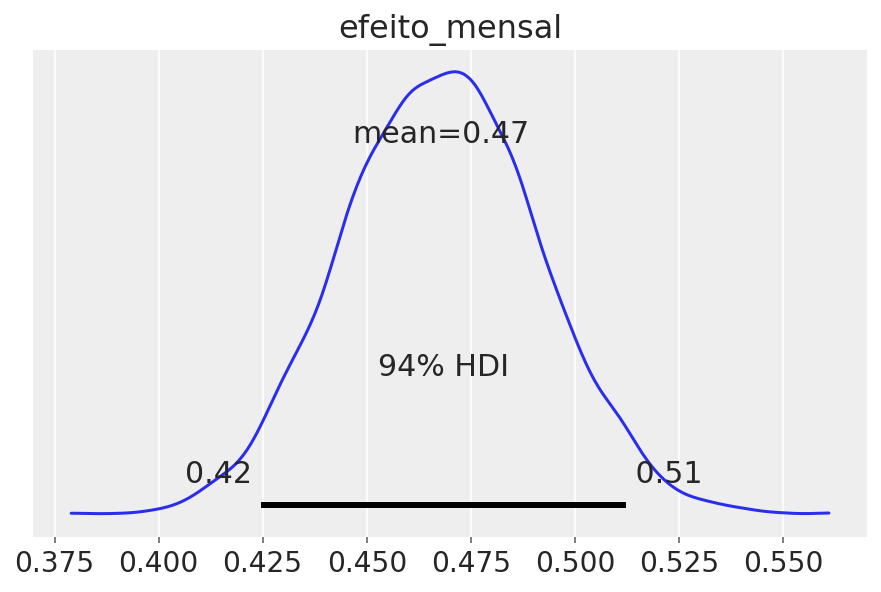

In [24]:
az.plot_posterior(logistic(aprovacao_trace.posterior["efeito_mensal"].sel(mes=1)));

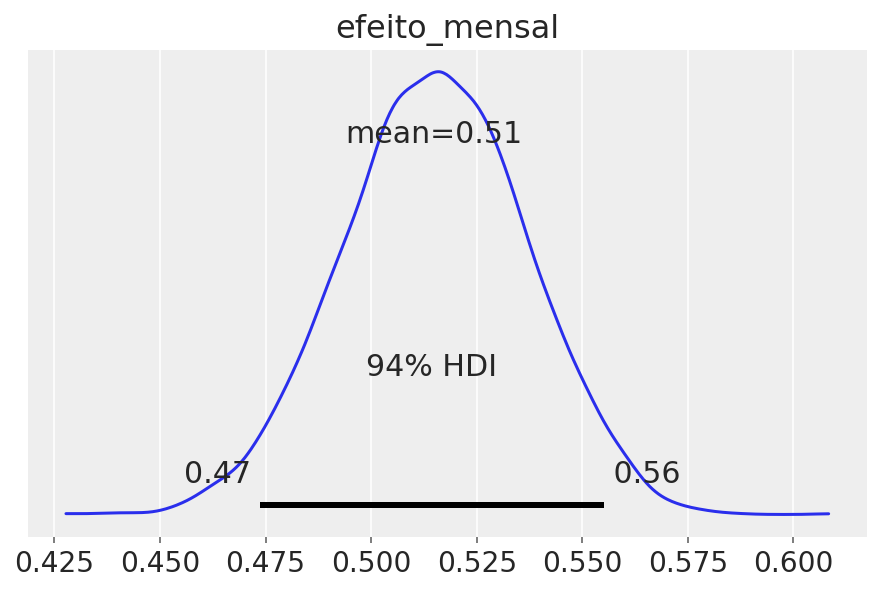

In [25]:
az.plot_posterior(logistic(aprovacao_trace.posterior["efeito_mensal"].sel(mes=4)));

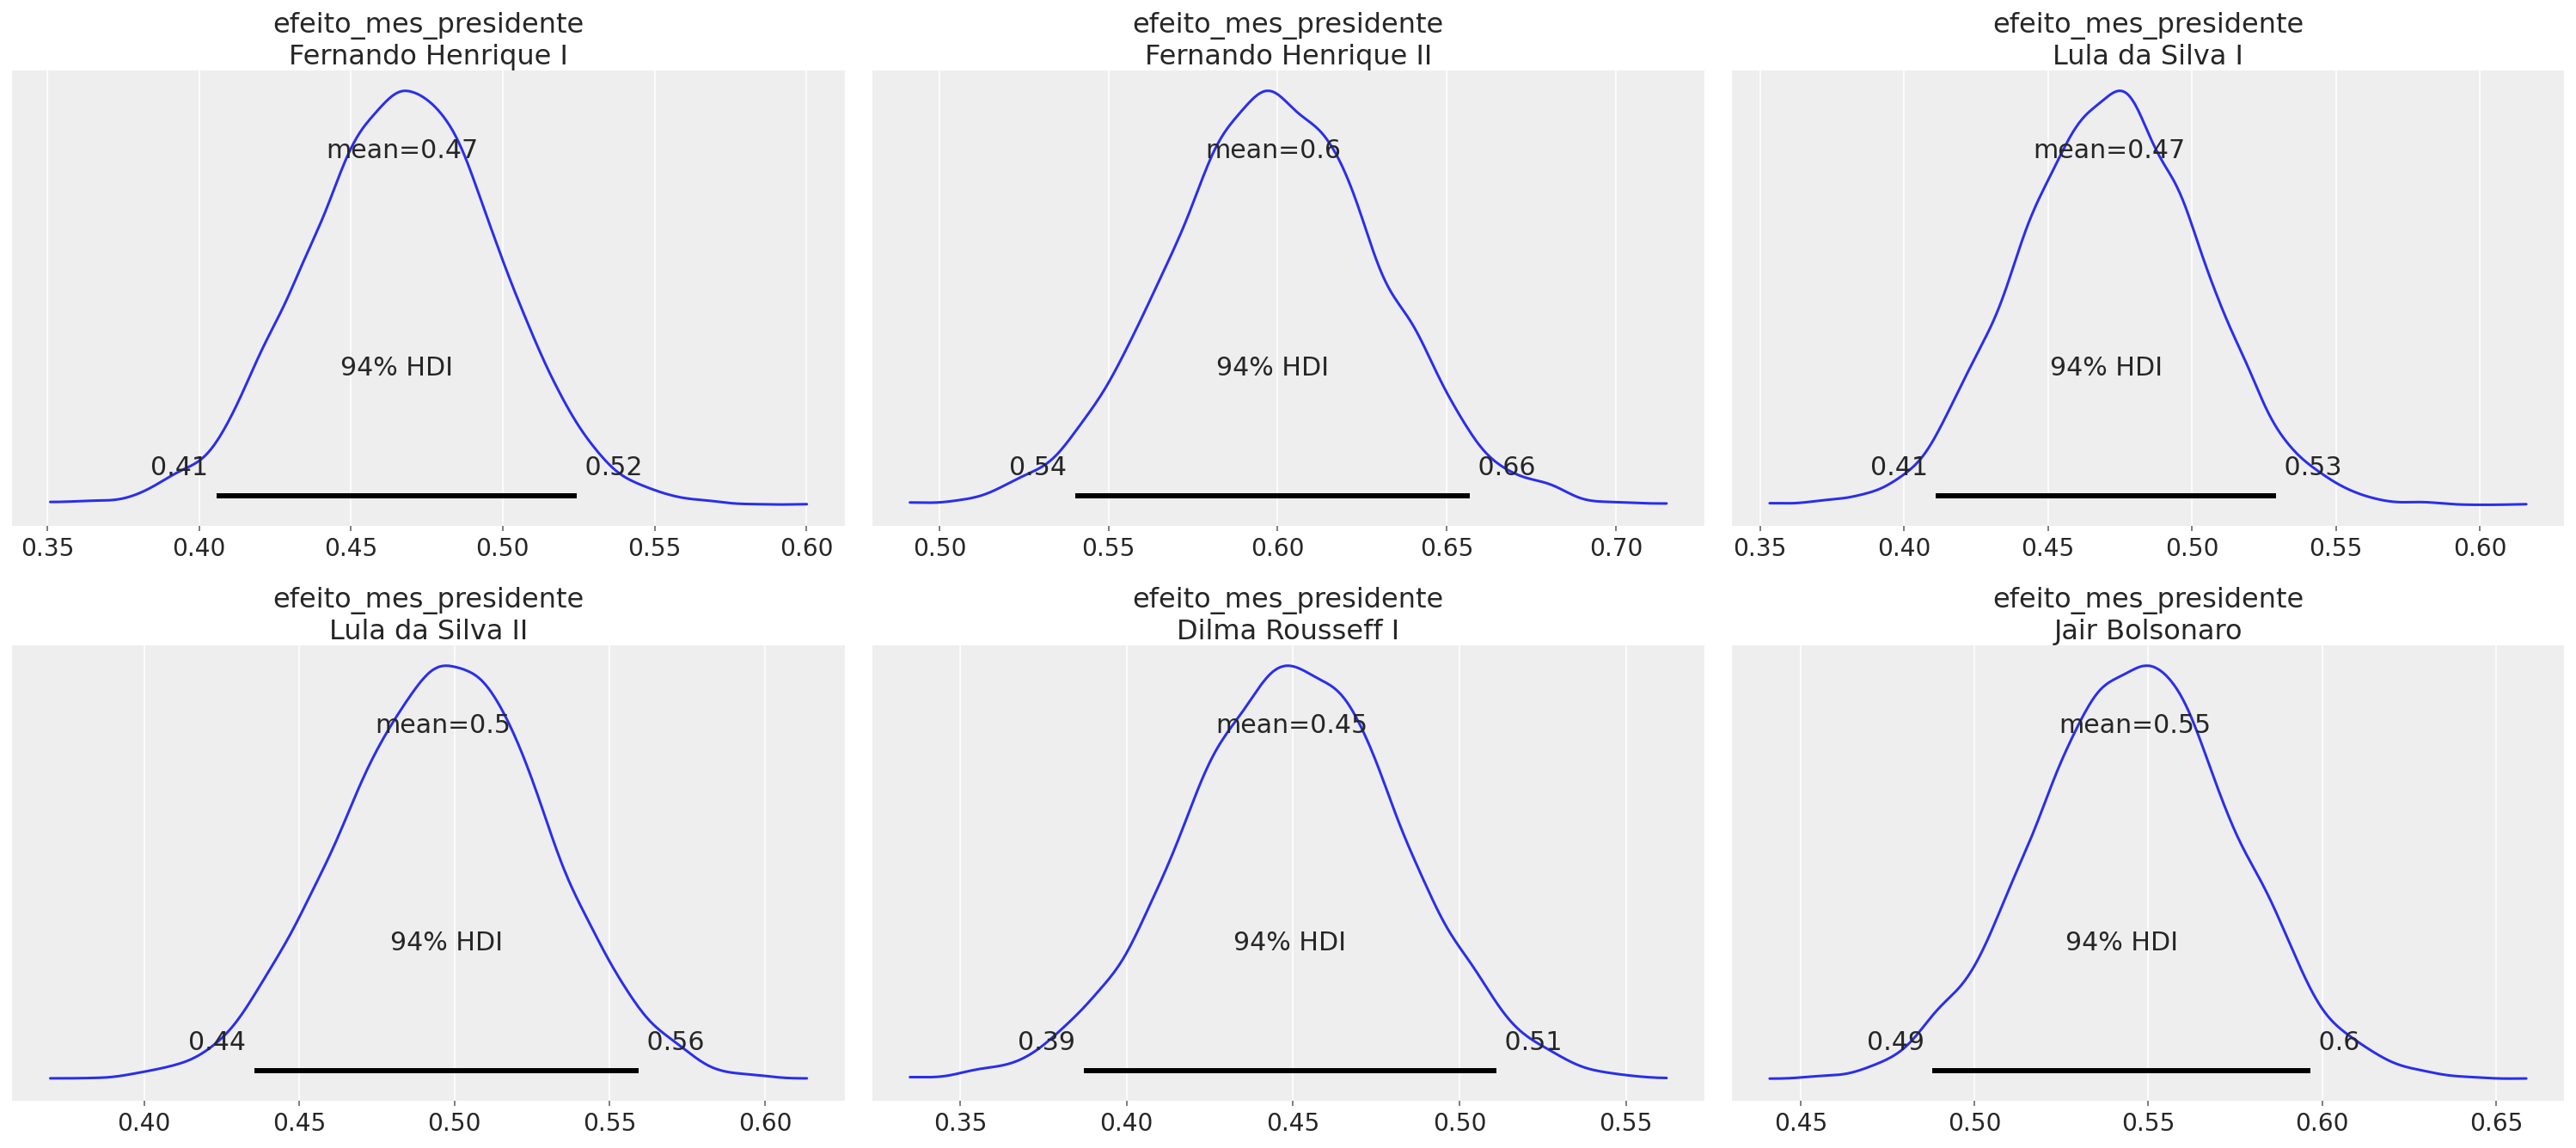

In [26]:
az.plot_posterior(logistic(aprovacao_trace.posterior["efeito_mes_presidente"].sel(mes=1)));

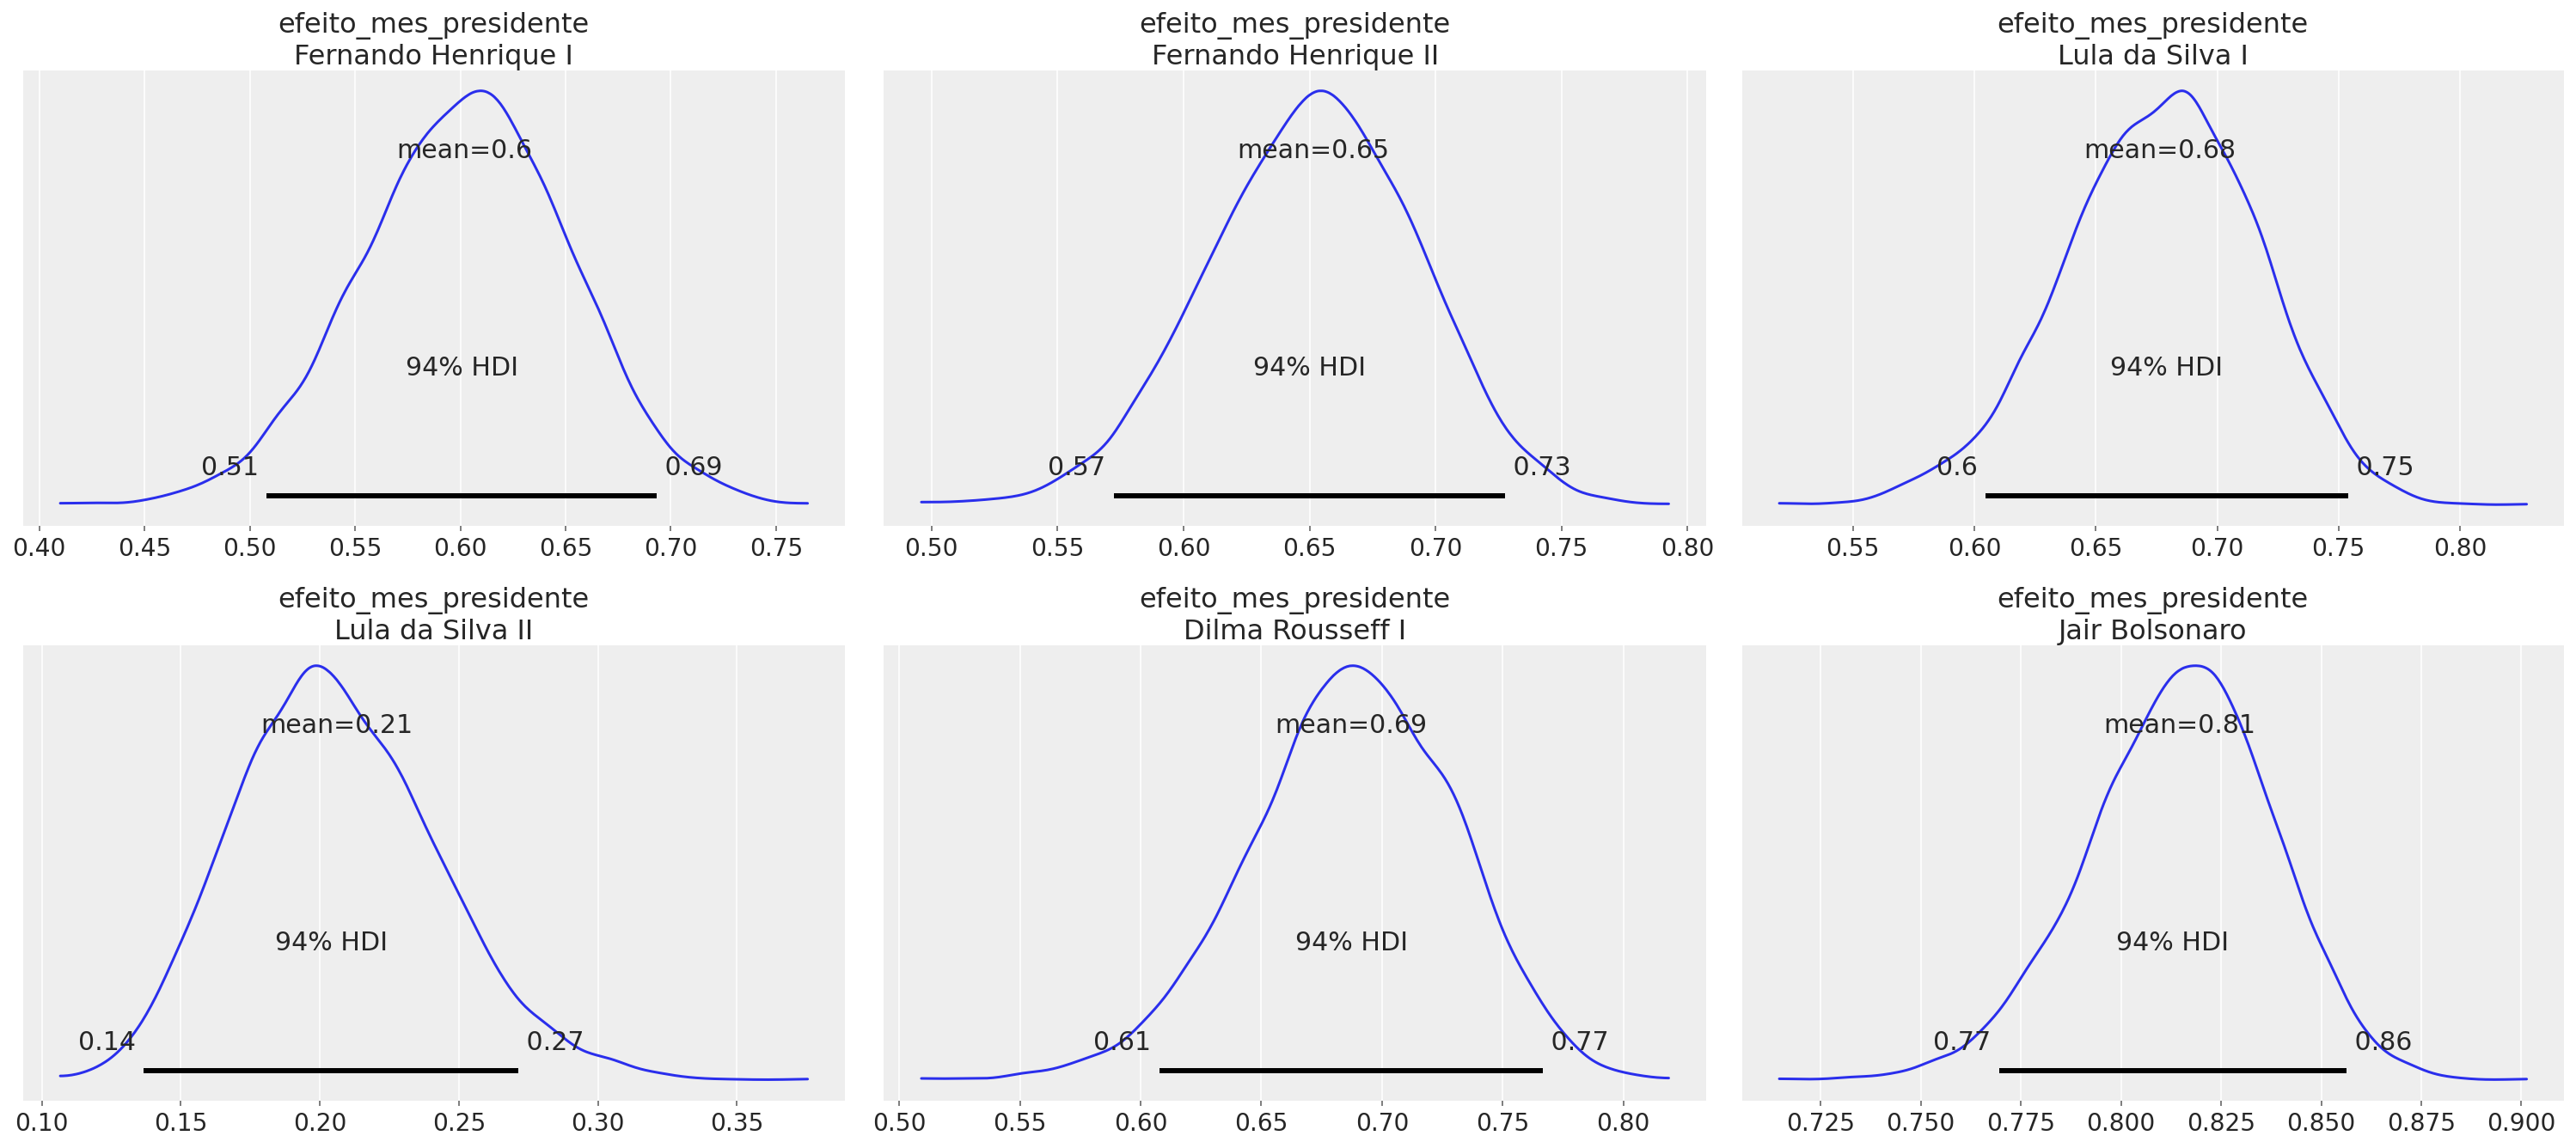

In [27]:
az.plot_posterior(logistic(aprovacao_trace.posterior["efeito_mes_presidente"].sel(mes=32)));

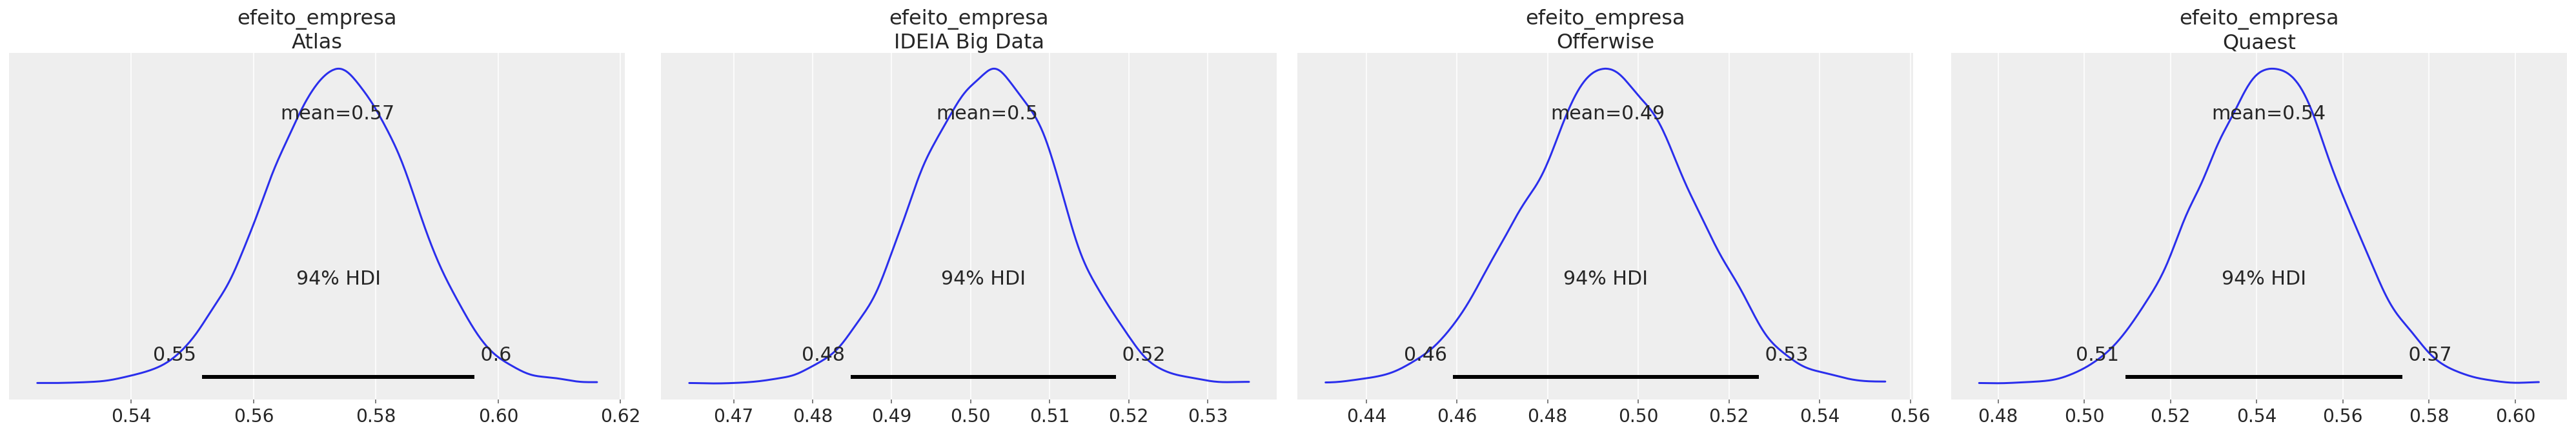

In [28]:
az.plot_posterior(logistic(aprovacao_trace.posterior["efeito_empresa"].sel(empresa_por_metodo_level_1="Internet")));

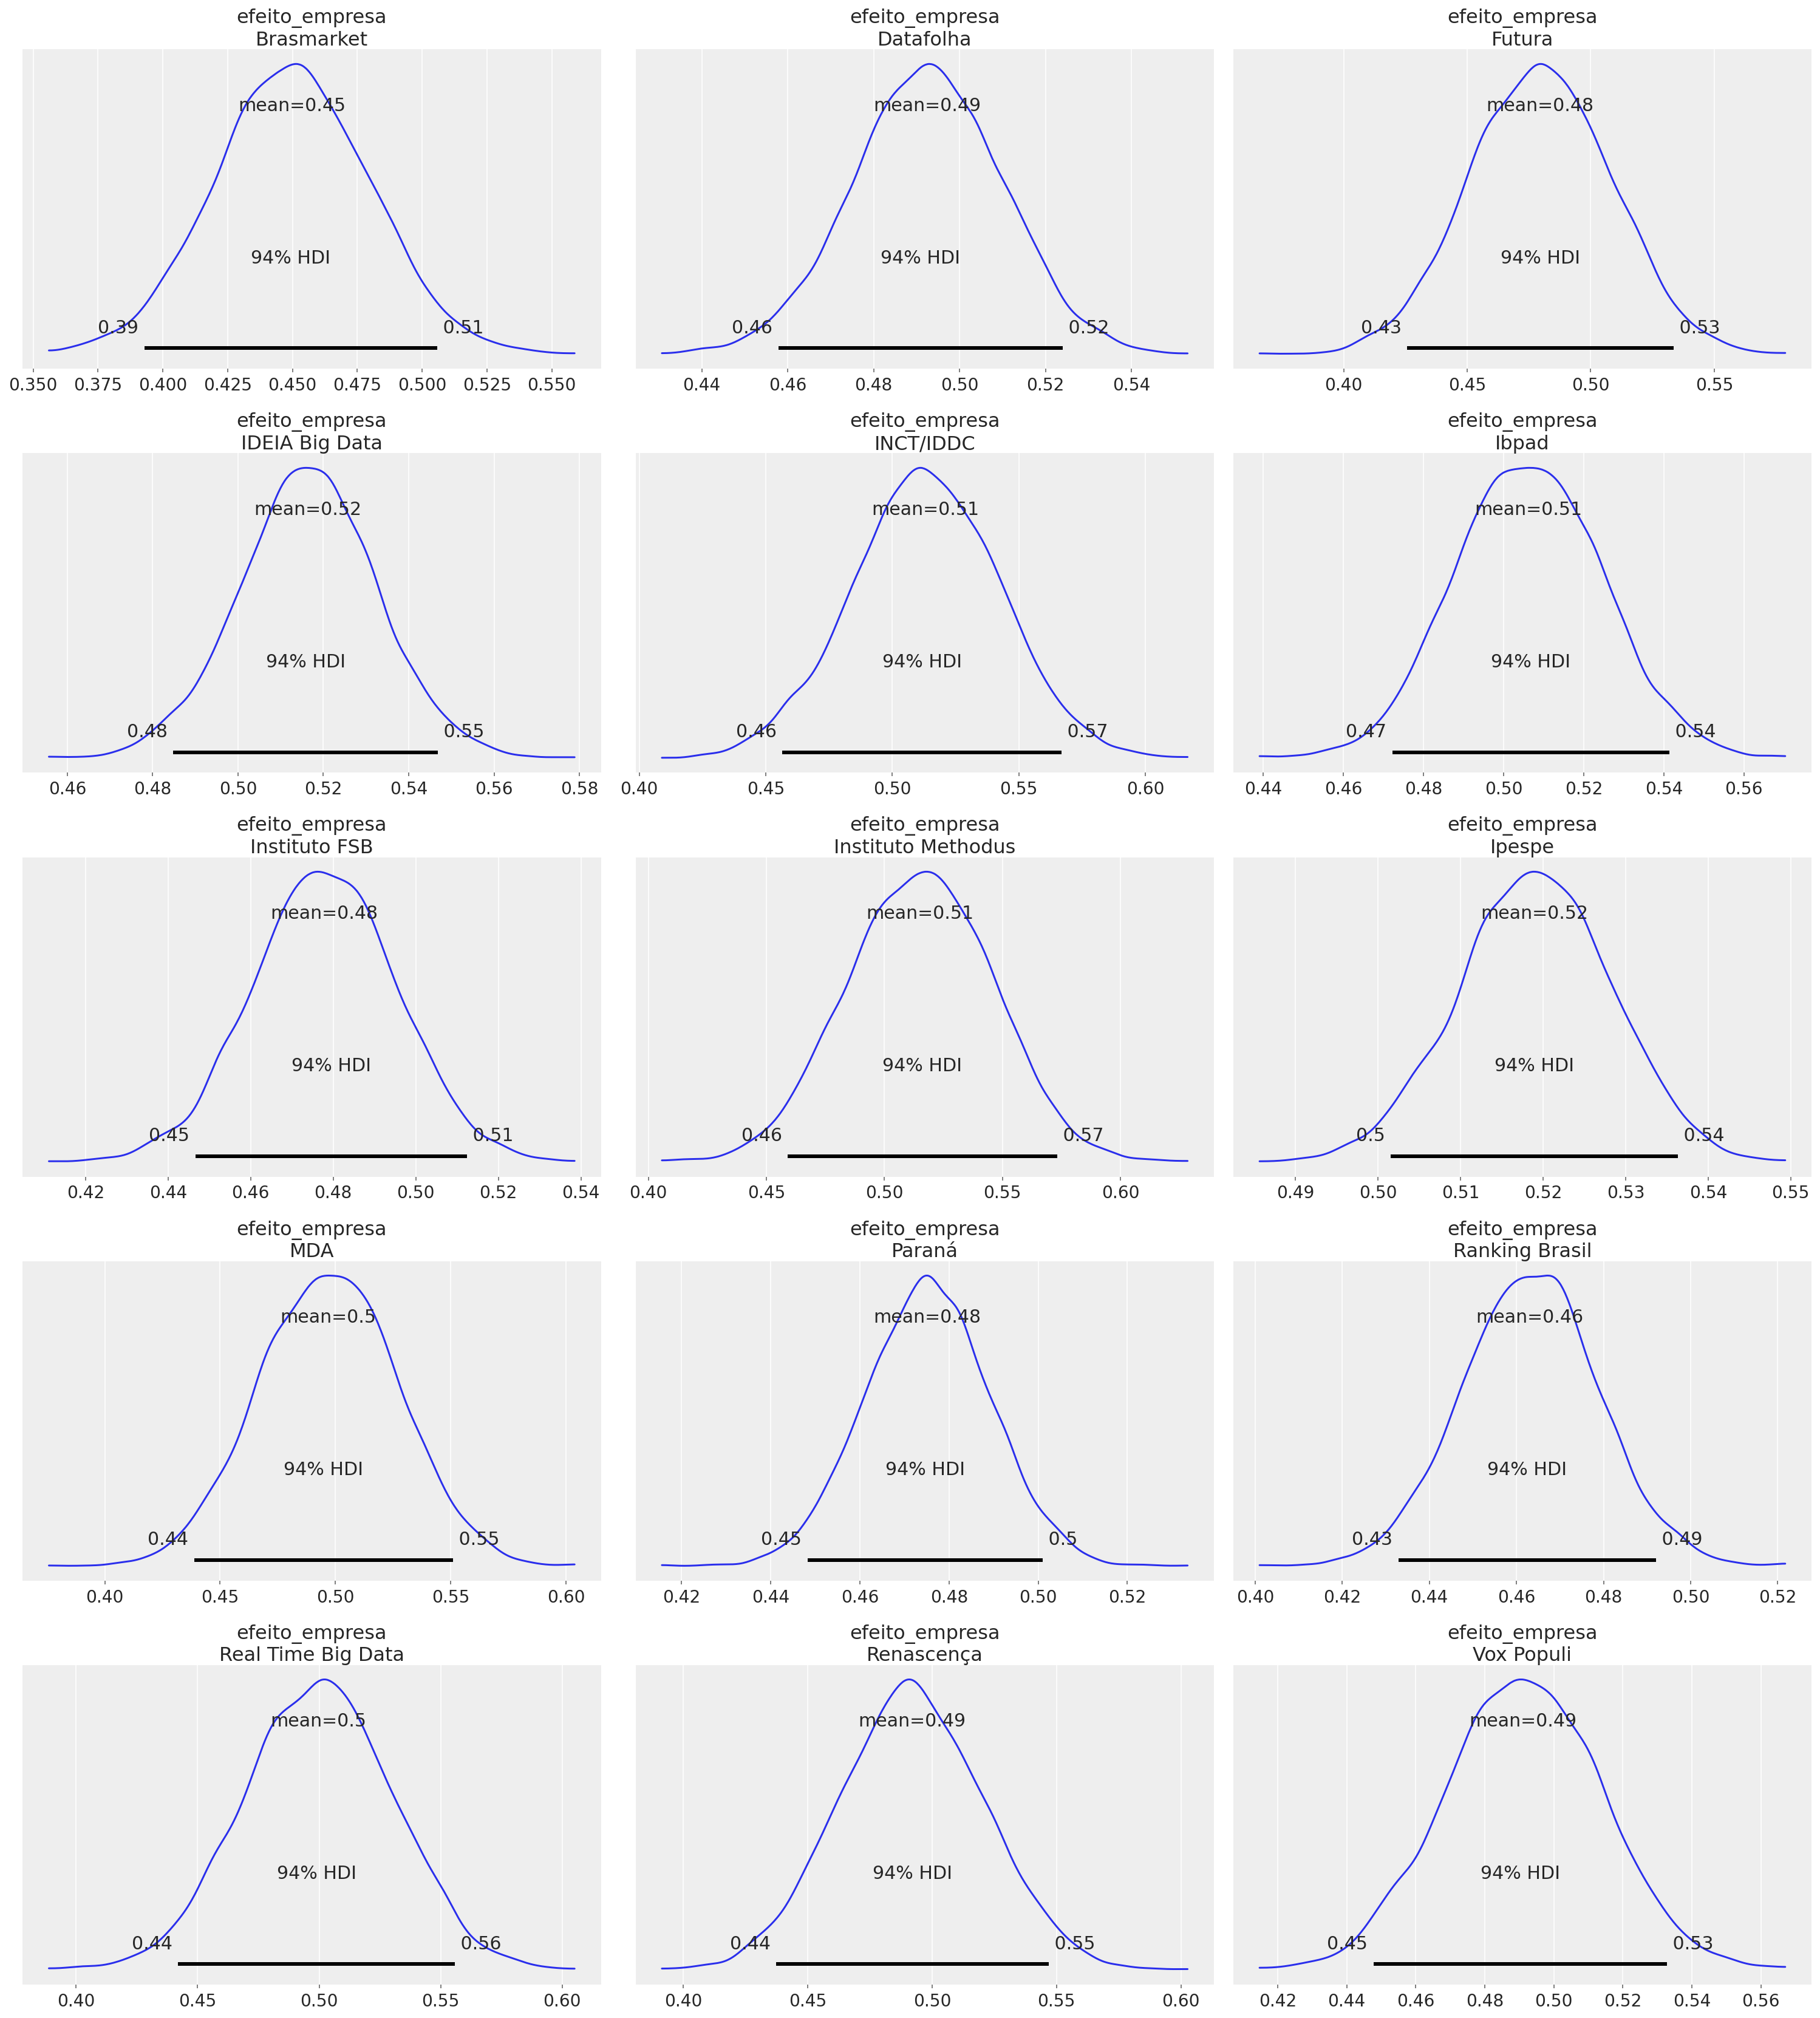

In [29]:
az.plot_posterior(logistic(aprovacao_trace.posterior["efeito_empresa"].sel(empresa_por_metodo_level_1="CATI")));

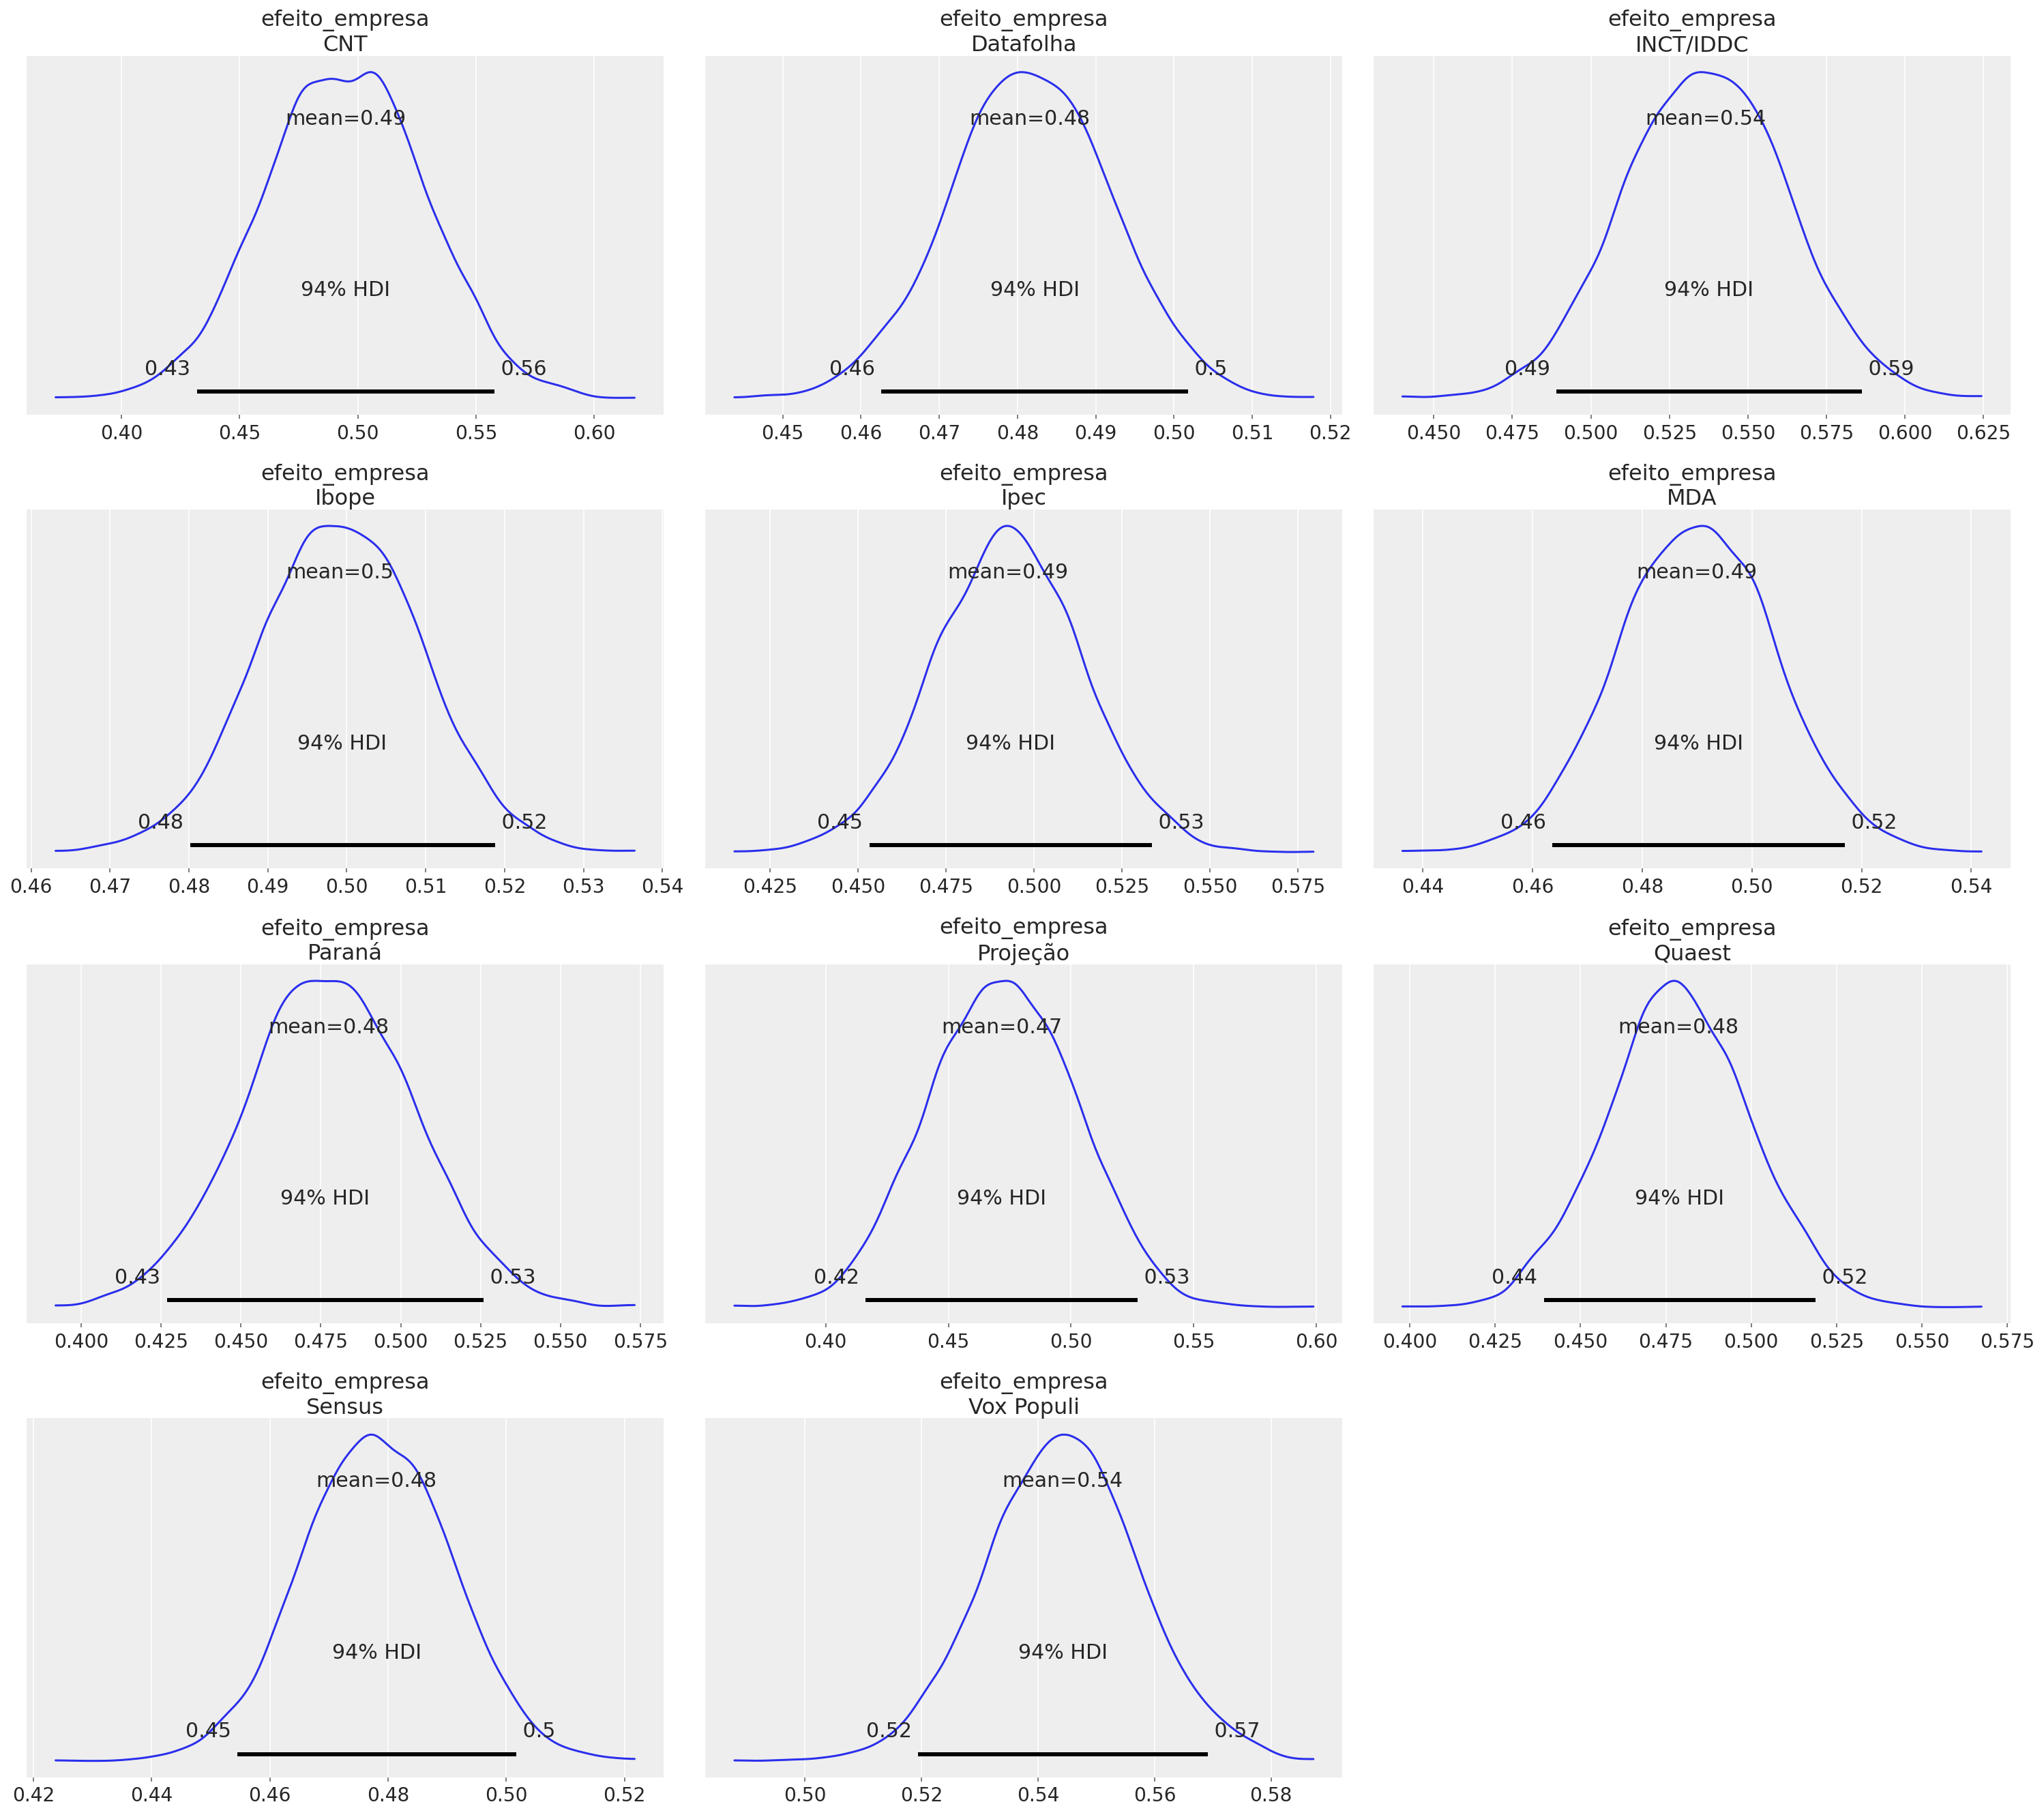

In [30]:
az.plot_posterior(logistic(aprovacao_trace.posterior["efeito_empresa"].sel(empresa_por_metodo_level_1="Presencial")));

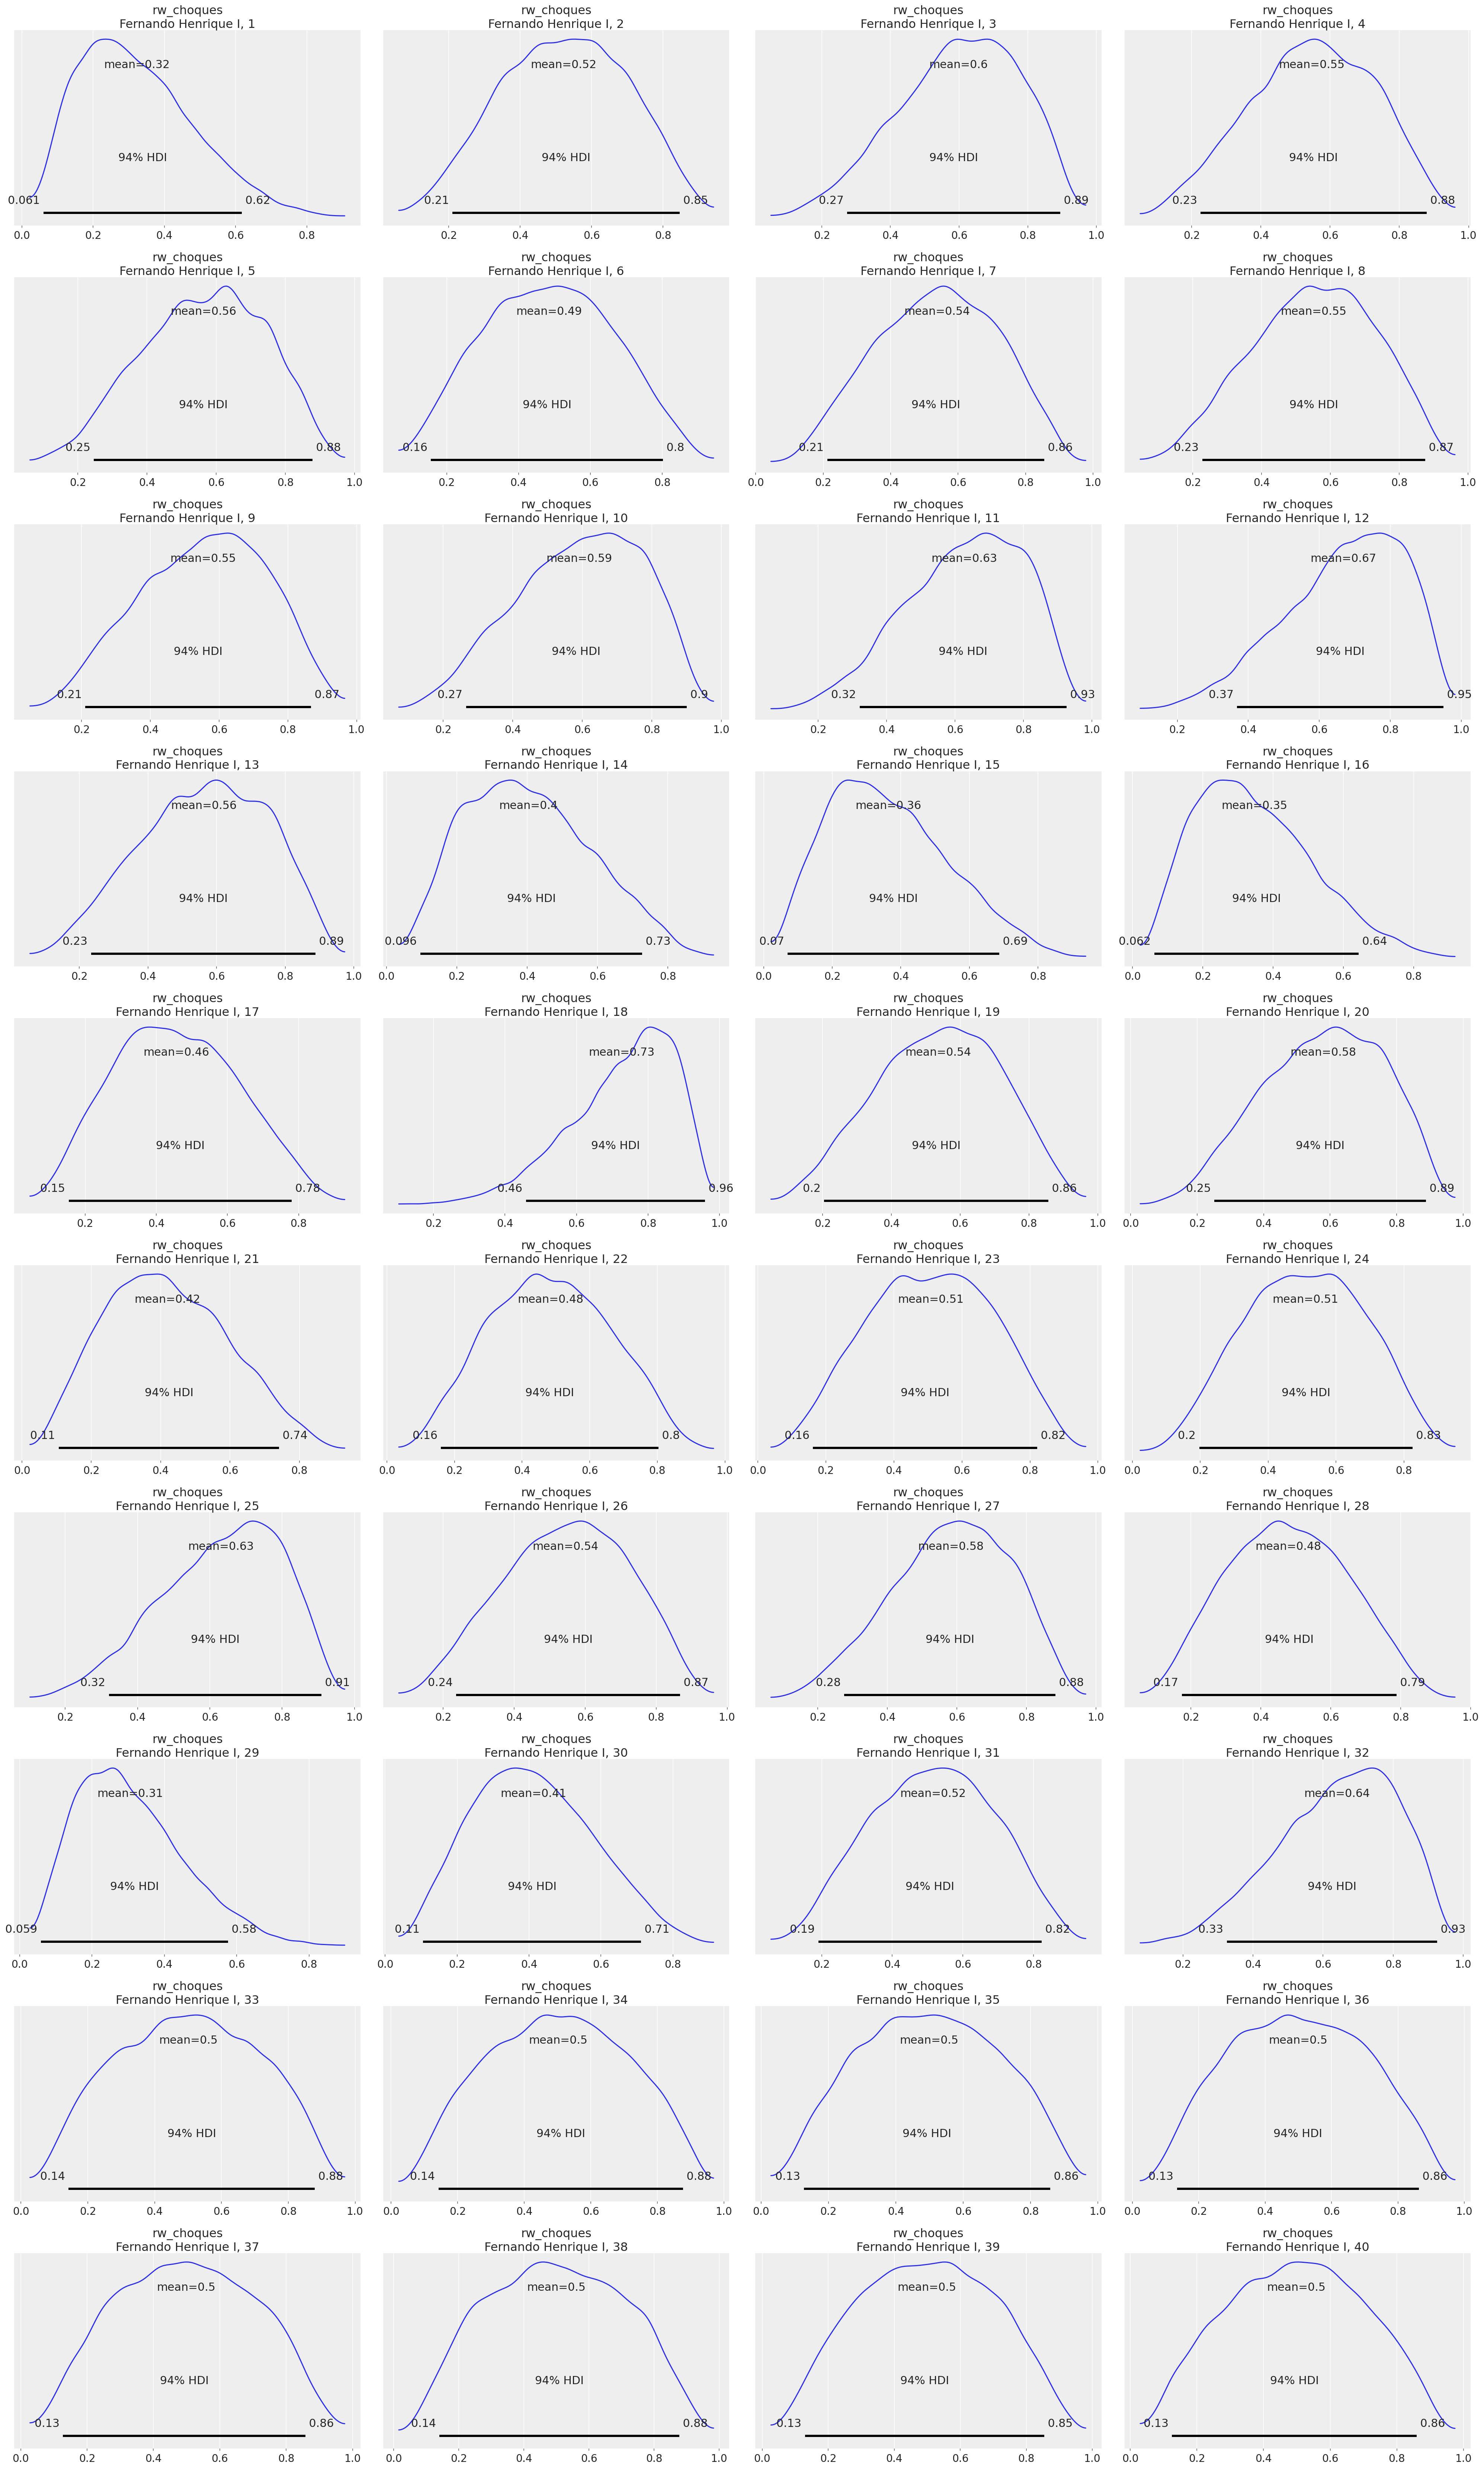

In [31]:
az.plot_posterior(logistic(aprovacao_trace.posterior["rw_choques"]));

## Vamos ver as imagens 


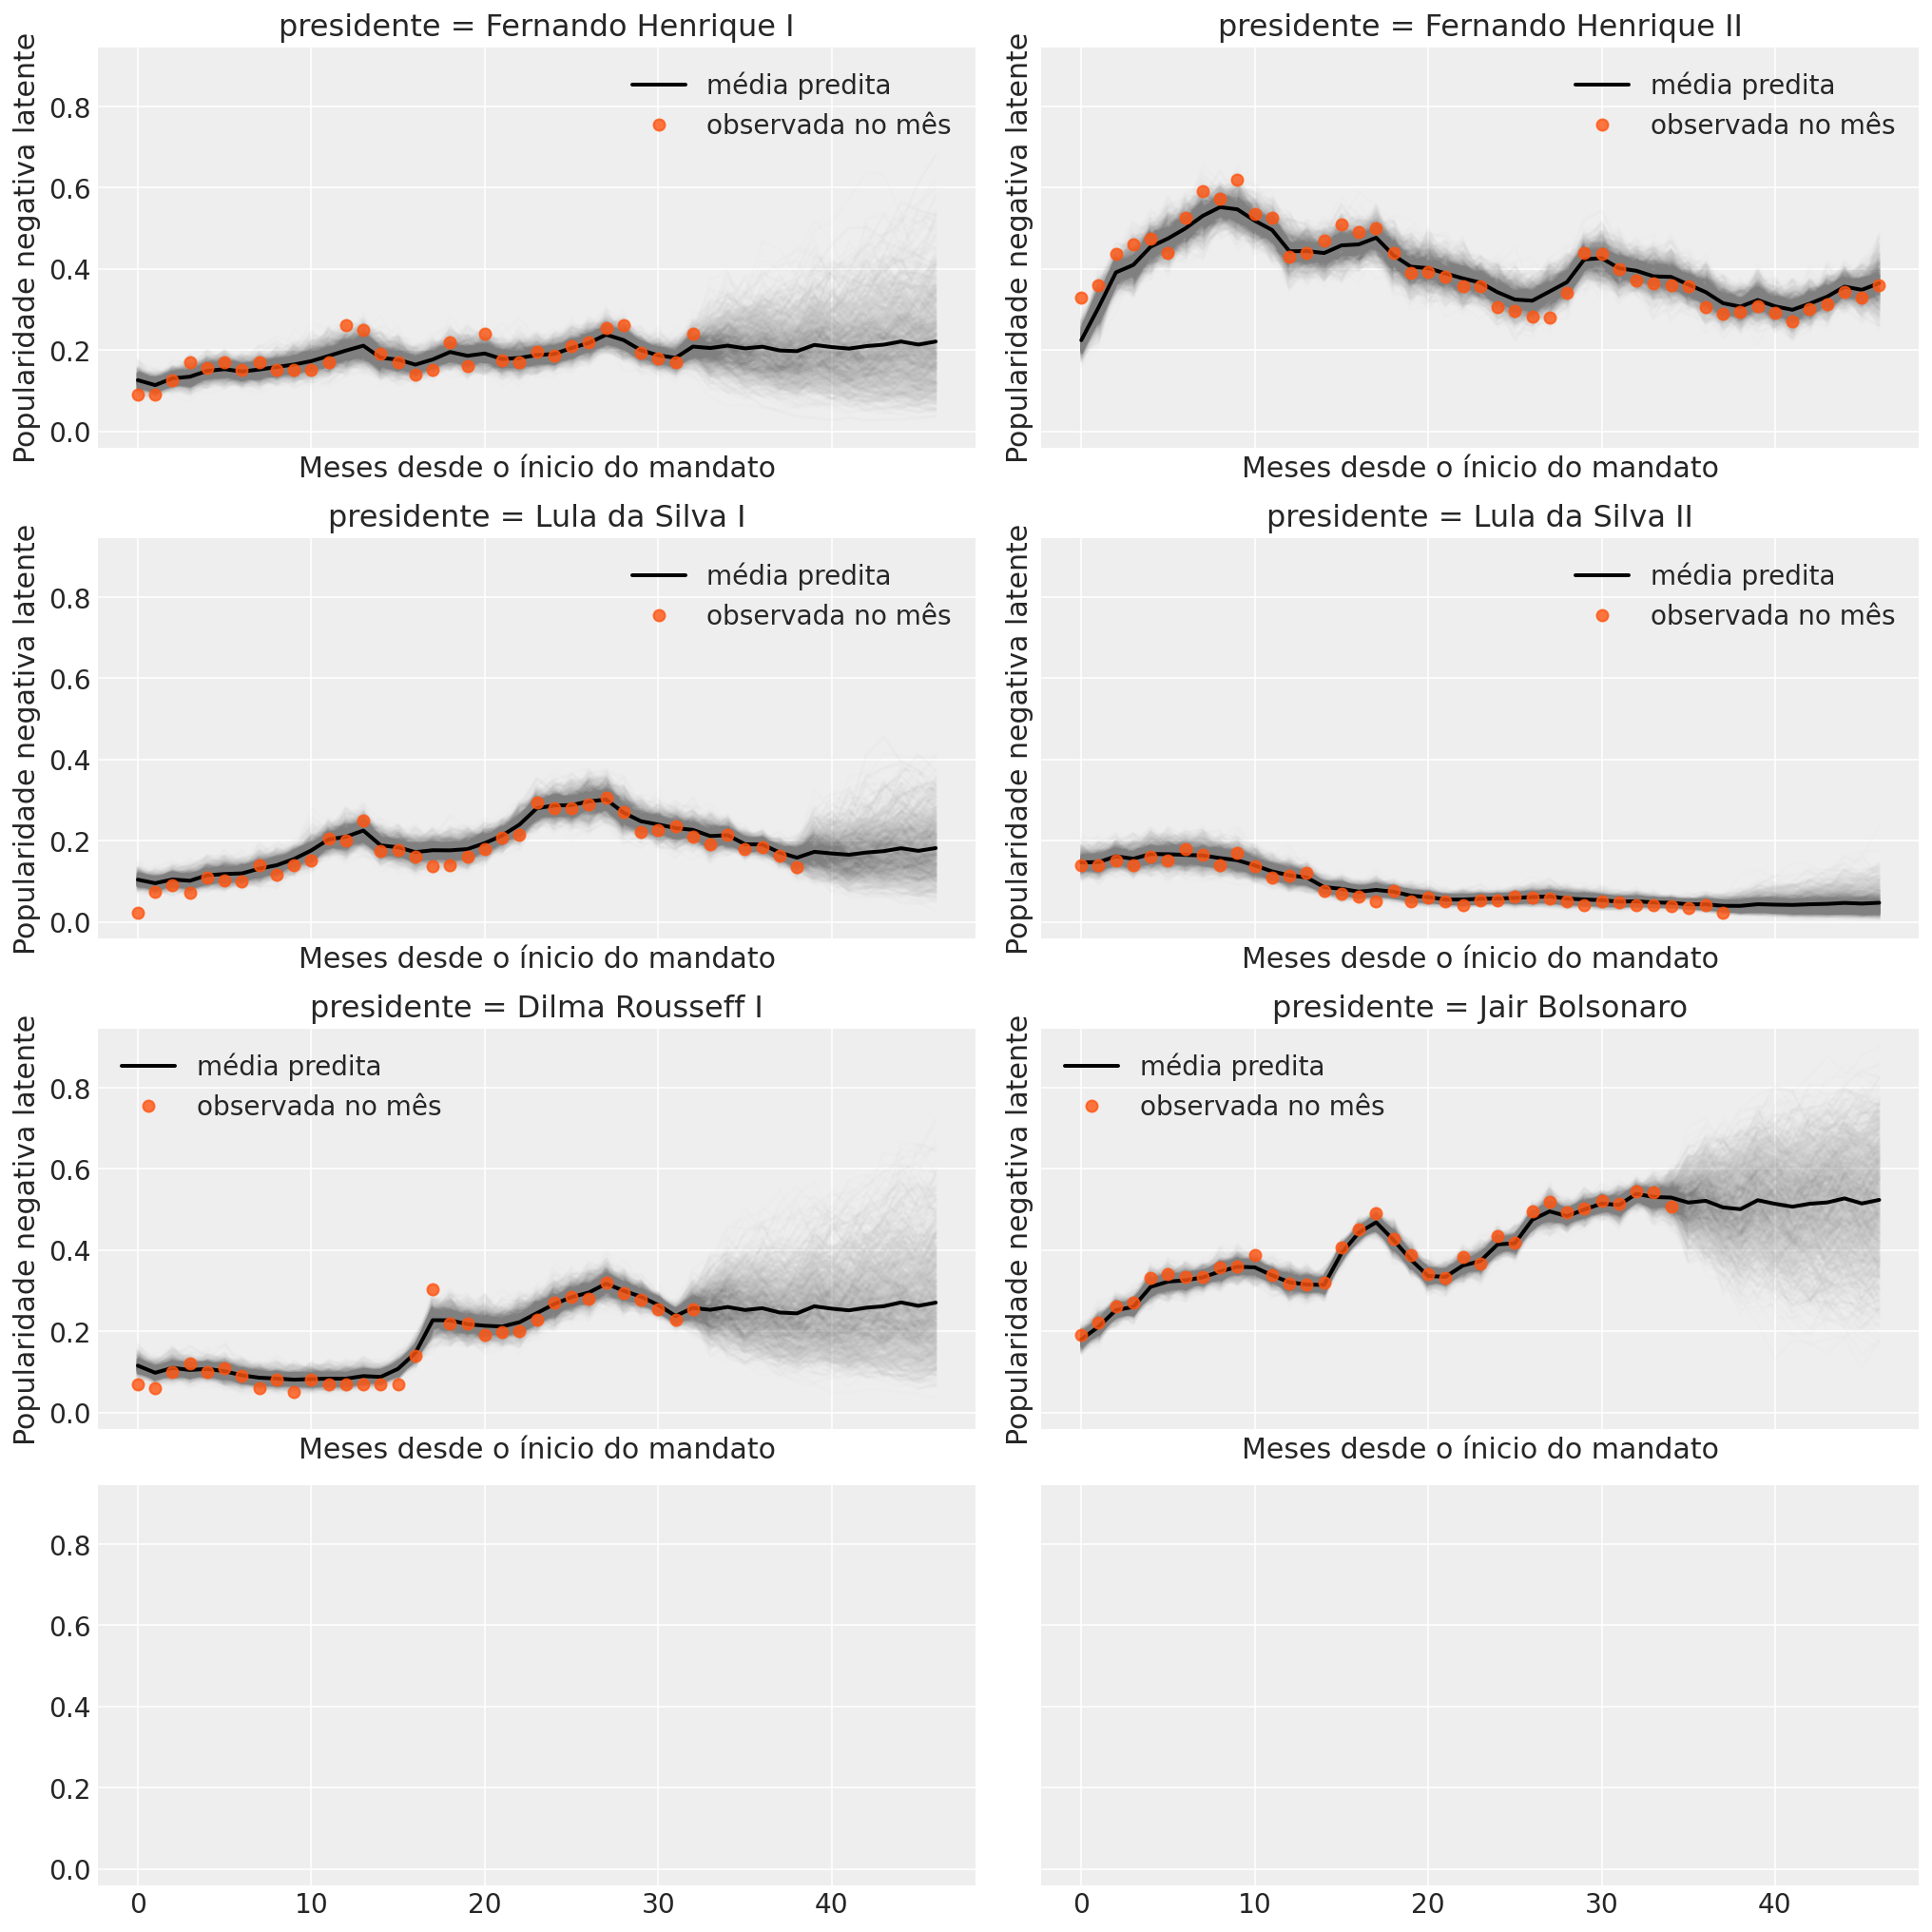

In [32]:
fig, axes = plt.subplots(4, 2, figsize=(14, 14), sharex=True, sharey=True)
for ax, p in zip(axes.ravel(), aprovacao_trace.posterior.coords["presidente"]):
    posterior = aprovacao_trace.posterior.sel(presidente=p)
    aprovacao_posterior = logistic(
        (
            posterior["baseline"]
            + posterior["efeito_presidente"]
            + posterior["efeito_mensal"]
            + posterior["efeito_mes_presidente"]
        ).stack(sample=("chain", "draw"))
    )
    # plot random posterior draws
    ax.plot(
        posterior.coords["mes"],
        aprovacao_posterior.isel(
            sample=np.random.choice(aprovacao_posterior.coords["sample"].size, size=1000)
        ),
        alpha=0.01,
        color="grey",
    )
    # plot posterior mean
    aprovacao_posterior.mean("sample").plot(ax=ax, color="black", lw=2, label="média predita")
    
    # plot monthly raw polls
    ax.plot(
        obs_media.index,
        obs_media[p.data],
        "o",
        color="#FF5511", # "#17DD0F" #BBFF11 #11BBFF
        alpha=0.8,
        label="observada no mês",
    )
    ax.set_xlabel("Meses desde o ínicio do mandato")
    ax.set_ylabel("Popularidade negativa latente")
    ax.legend()

## Inferência a partir da Distribuição Posterior

Vamos olhar as distribuições preditivas da posterior, só vamos considerar as estimativas quando o modelo convergir amostrar e convergir corretamente. 

In [33]:
with hierarchical_monthly_popularity:
    aprovacao_trace.extend(
        az.from_pymc3(
            posterior_predictive = pm.sample_posterior_predictive(aprovacao_trace),
        )
    )

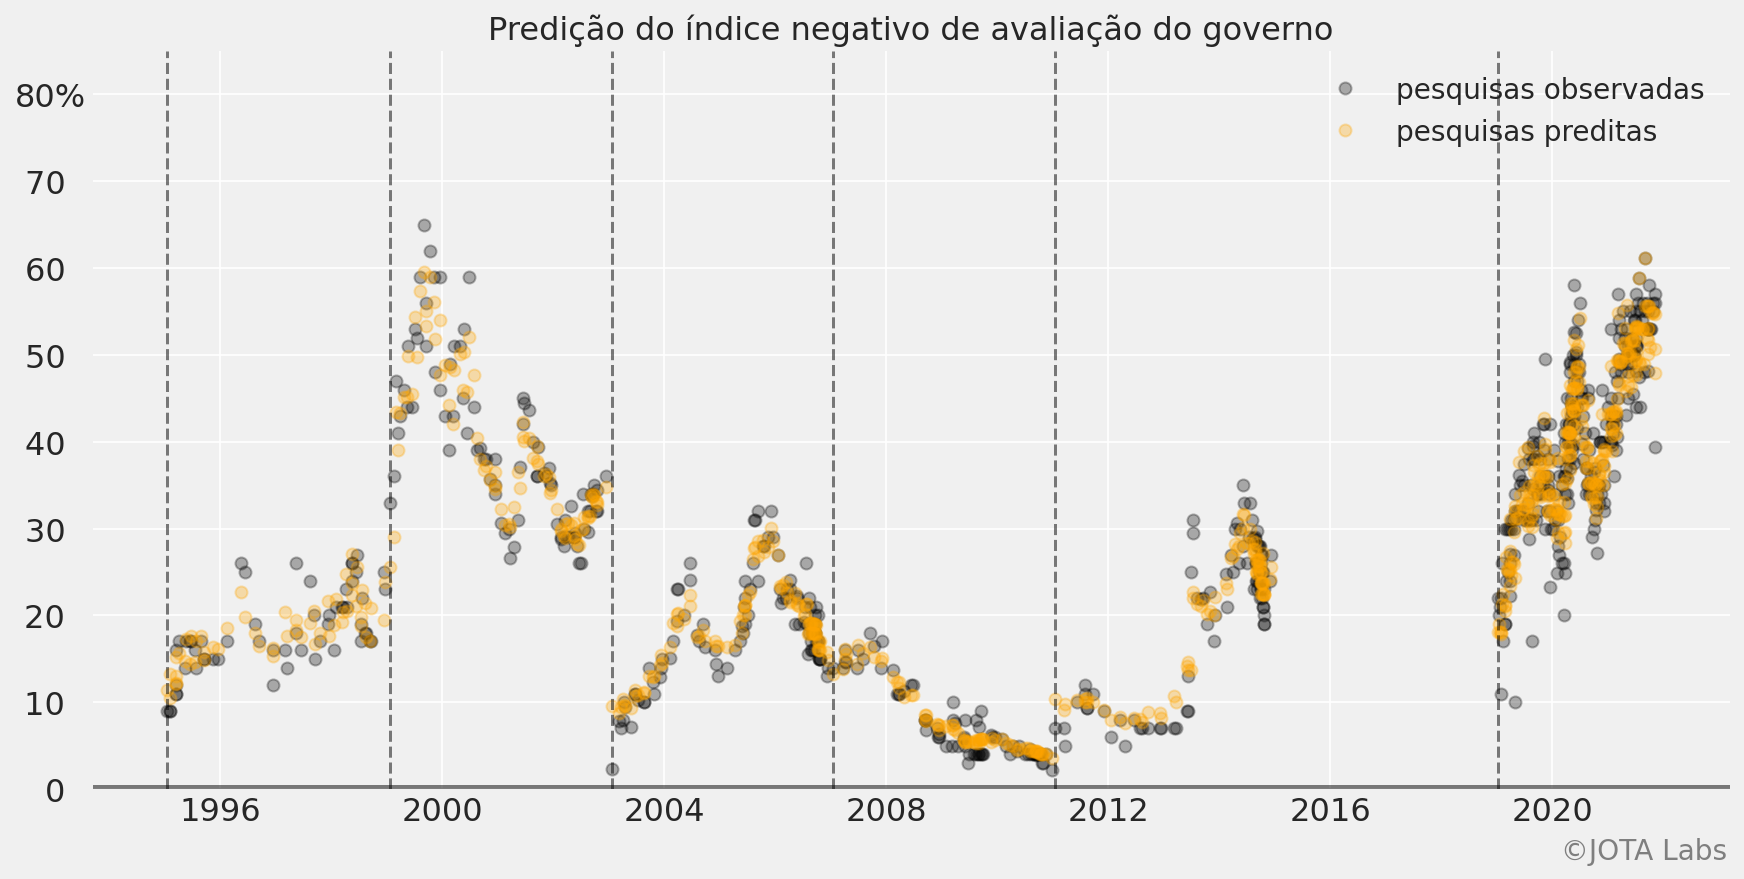

In [34]:
aprovacao_predita = (
    aprovacao_trace.posterior_predictive.mean(("chain", "draw"))["aprovacao_latente"] / data["amostra"]
)

dates = aprovacao_predita.data_fim
newterm_dates = data.groupby("presidente").first()["data_fim"].values

fig, ax = plt.subplots(figsize=(12, 6), facecolor="#f0f0f0")
ax.set_facecolor("#f0f0f0")
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)

ax.plot(dates, 100*data["negativa"].values, "o", color="k", alpha=0.3, label="pesquisas observadas")
ax.plot(dates, 100*aprovacao_predita, "o", alpha=0.3, color="orange", label="pesquisas preditas")

ax.set_yticklabels(labels = ['0  ', '10  ', '20  ', '30  ', '40  ', '50  ', '60  ', '70  ', '80%'])
ax.set_ylim(0, 85)
ax.set_title("Predição do índice negativo de avaliação do governo")
ax.axhline(y = 0, color = 'black', linewidth = 4, alpha = .5)
# ax.set_title("Predição do índice negativo de avaliação", fontsize = 22, weight = 'bold', alpha = .75)
ax.text(x = pd.to_datetime("2020-01-01"), y = -8, s = ' ©JOTA Labs', fontsize = 14, color = '#7F7F7F', backgroundcolor = '#f0f0f0');
ax.legend()
for date in newterm_dates:
    ax.axvline(date, color="k", alpha=0.5, linestyle="--")

In [35]:
data['previsto'] = (aprovacao_trace.posterior_predictive.mean(("chain", "draw"))["aprovacao_latente"]) / data["amostra"]

# subset
observado_previsto = data[['data_fim', 'empresa', 'negativa','previsto']]

observado_previsto['negativa'] = (observado_previsto['negativa']*100).round(1)
observado_previsto['previsto'] = (observado_previsto['previsto']*100).round(1)
observado_previsto["diff"] = (observado_previsto['negativa'] - observado_previsto['previsto'])
# observado_previsto['serie'] = 'positiva'

observado_previsto = observado_previsto.rename(columns={'negativa': 'observado'})

observado_previsto.round(3).to_csv('negativa_observado_previsto.csv', sep=";", index=False)

observado_previsto

data_fim     empresa  observado  previsto  diff
0   1995-01-15    Projeção        9.0      11.4  -2.4
1   1995-02-07      Sensus        9.0      10.5  -1.5
2   1995-02-07  Vox Populi        9.0      13.2  -4.2
3   1995-03-13      Sensus       11.0      12.1  -1.1
4   1995-03-13  Vox Populi       11.0      15.2  -4.2
..         ...         ...        ...       ...   ...
664 2021-10-27   PoderData       56.0      54.9   1.1
665 2021-10-28      Ipespe       55.0      55.0   0.0
666 2021-11-06      Quaest       56.0      50.7   5.3
667 2021-11-07  Brasmarket       39.4      47.9  -8.5
668 2021-11-10   PoderData       57.0      54.7   2.3

[669 rows x 5 columns]

### Agregação da popularidade mensal e cálculo do HDI
- Calculamos o intervalo de maior densidade (Highest Density Interval - HDI) das distribuições posterior. Todos os pontos dentro das bandas do intervalo têm uma grande densidade probabilística comparado aos pontos fora desse intervalo. A medida HDI pode ser usada em contextos de incerteza para caracterização das distribuições posteriores como Intervalo de Credibilidade (Credible Interval - CI).

In [36]:

pprob = aprovacao_trace.posterior_predictive["aprovacao_latente"][0, :] / np.atleast_2d(
    data["amostra"]
)

# Limit ourselves to Bolsonaro's term
dates = pprob["data_fim"].values
bolsonaro_first_date = np.min(data.loc[data.presidente == "Jair Bolsonaro"]["data_fim"])

limite = dates >= bolsonaro_first_date
pprob = pprob[:, limite]
dates = dates[limite]

mes_int = pd.Categorical(pd.DataFrame(dates)[0].dt.to_period("M")).codes

In [37]:
hdi_50_lower = []
hdi_50_upper = []
hdi_90_lower = []
hdi_90_upper = []

for mes in set(mes_int):
    limite = mes_int == mes
    probs_flat = pprob[:, limite].values.flatten()
    lower, upper = az.hdi(probs_flat, 0.5)
    hdi_50_lower.append(lower)
    hdi_50_upper.append(upper)
    lower, upper = az.hdi(probs_flat, 0.9)
    hdi_90_lower.append(lower)
    hdi_90_upper.append(upper)

## Exportar os dados para o dashboard

Vamos exportar os dados relativos ao último mandato presidencial.

### Mediana, 50% HDI e 95% HDI

Primeiramente calculamos a predição posterior da popularidade latente somando todos os efeitos, exceto o house effects:

In [38]:
posterior = aprovacao_trace.posterior.sel(presidente="Jair Bolsonaro")
        
aprovacao_posterior = logistic(
    (
        posterior["baseline"]
        + posterior["efeito_presidente"]
        + posterior["efeito_mensal"]
        + posterior["efeito_mes_presidente"]
    ).stack(sample=("chain", "draw"))
)

medias_bolsonaro = aprovacao_posterior.mean("sample")  # Average posterior latent popularity

In [39]:
dates = [datetime.date(2019, 1, 1) + relativedelta(months=i) for i in range(48)]

resultados = pd.DataFrame(
    {
        "date": dates[: len(hdi_50_lower)],
        "mean": medias_bolsonaro[: len(hdi_50_lower)],
        "hdi_50_lower": hdi_50_lower,
        "hdi_50_upper": hdi_50_upper,
        "hdi_90_lower": hdi_90_lower,
        "hdi_90_upper": hdi_90_upper,
        "label": "negativo",
    }
)

resultados.to_csv("../exports/popularidade_negativa.csv", index=False)

## Vamos plotar alguns gráficos estáticos comparando as curvas

In [40]:
mes_int_max = np.max(
    pd.Categorical(data[data.presidente == "Jair Bolsonaro"].data_fim.dt.to_period("M")).codes
) + 1

In [41]:
# Colorblind-friendly colors
colors = [[0,0,0], [230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255],
          [213/255,94/255,0], [0,114/255,178/255]]

month = 35

def plot_static_curve(presidente: str):
    posterior = aprovacao_trace.posterior.sel(presidente=presidente)
    medias_presidente = 100 * logistic(
        (
            posterior["baseline"]
            + posterior["efeito_presidente"]
            + posterior["efeito_mensal"]
            + posterior["efeito_mes_presidente"]
        ).stack(sample=("chain", "draw"))
    ).mean("sample")

    posterior = aprovacao_trace.posterior.sel(presidente="Jair Bolsonaro")
    medias_bolsonaro = 100 * logistic(
        (
            posterior["baseline"]
            + posterior["efeito_presidente"]
            + posterior["efeito_mensal"]
            + posterior["efeito_mes_presidente"]
        ).stack(sample=("chain", "draw"))
    ).mean("sample")


    fig, ax = plt.subplots(figsize=(14, 8), facecolor="#f0f0f0")
    ax.set_facecolor("#f0f0f0")
    ax.plot(medias_presidente, color="#3B4252", lw=4)
    # ax.text(x = 40, y = 47, s = presidente, color="#3B4252", weight = 'bold')
    ax.plot(medias_bolsonaro[:mes_int_max+1], color="#4682b4", lw=4)
    ax.set_xticks([0, 12, 24, 36, 48])
    ax.set_xticklabels(["", "1 ANO", "2", "3", "4"])
    # ax.set_yticks([30, 50, 70, 85])
    # ax.set_yticklabels(["30%", "50%", "70%", "85%"])
    ax.set_yticks([0, 25, 50, 75])   
    ax.set_yticklabels(["0%", "25%", "50%", "75%"])
    ax.set_ylim(0, 80)

    ax.xaxis.set_tick_params(labelsize=25, labelcolor="#c4c9cc")
    ax.yaxis.set_tick_params(labelsize=25, labelcolor="#c4c9cc")
    ax.get_yticklabels()[2].set_color("#3B4252")

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

    ax.axvline(0, alpha=0.1, color="grey")
    ax.axvline(11, alpha=0.1, color="grey")
    ax.axvline(23, alpha=0.1, color="grey")
    # ax.axvline(33, color="red", lw=0.8, linestyle="--")
    ax.axvline(35, alpha=0.1, color="grey")
    ax.axvline(47, alpha=0.1, color="grey")

    ax.axhline(0, alpha=0.2, color="grey")
    ax.axhline(25, alpha=0.2, color="grey")
    ax.axhline(50, alpha=1, color="black", lw=0.8, linestyle="--")
    ax.axhline(75, alpha=0.2, color="grey")
    
    # anotation
    label0 = "{:.0f}%".format(medias_presidente.loc[month].values)
    label1 = "{:.0f}%".format(medias_bolsonaro.loc[month].values)
    
    ax.annotate("Jair Bolsonaro",(0, 70), size=20, color="#4682b4", fontweight="bold",) 
    ax.annotate(presidente,(0, 75), size=20, color="#3B4252", fontweight="bold",) 
    
    ax.annotate(label0, xy=(month, medias_presidente.loc[month].values), xycoords='data', 
                size=18, color="#3B4252", fontweight="bold",
                xytext=(month, 40), textcoords='offset points',
                bbox=dict(boxstyle="round,pad=.3", fc="0.9", color="#3B4252"),
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="angle,angleA=0,angleB=90,rad=10"),
                )
    ax.annotate(label1, xy=(month, medias_bolsonaro.loc[month].values),  xycoords='data', 
                size=18, color="#4682b4", fontweight="bold",
                xytext=(-40, 40), textcoords='offset points',
                bbox=dict(boxstyle="round,pad=.3", fc="0.9", color="#4682b4"),
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="angle,angleA=0,angleB=90,rad=10"),
                )
    
    
    
    fig.tight_layout()
    
    plt.savefig(f"../exports/benchmark_negativo_{presidente}_bolsonaro.png", bbox_inches="tight")
    plt.savefig(f"../exports/benchmark_negativo_{presidente}_bolsonaro.svg", bbox_inches="tight")

In [60]:
posterior = aprovacao_trace.posterior.sel(presidente="Fernando Henrique I")
medias_presidente = 100 * logistic(
        (
            posterior["baseline"]
            + posterior["efeito_presidente"]
            + posterior["efeito_mensal"]
            + posterior["efeito_mes_presidente"]
        ).stack(sample=("chain", "draw"))
    ).mean("sample")
    
# min(medias_presidente.values)

medias_presidente.sel(mes=44) # agosto
medias_presidente.sel(mes=45) # setembro

<xarray.DataArray ()>
array(21.32378822)
Coordinates:
    presidente  <U19 'Fernando Henrique I'
    mes         int64 45

In [43]:
# plot_static_curve("Fernando Collor")

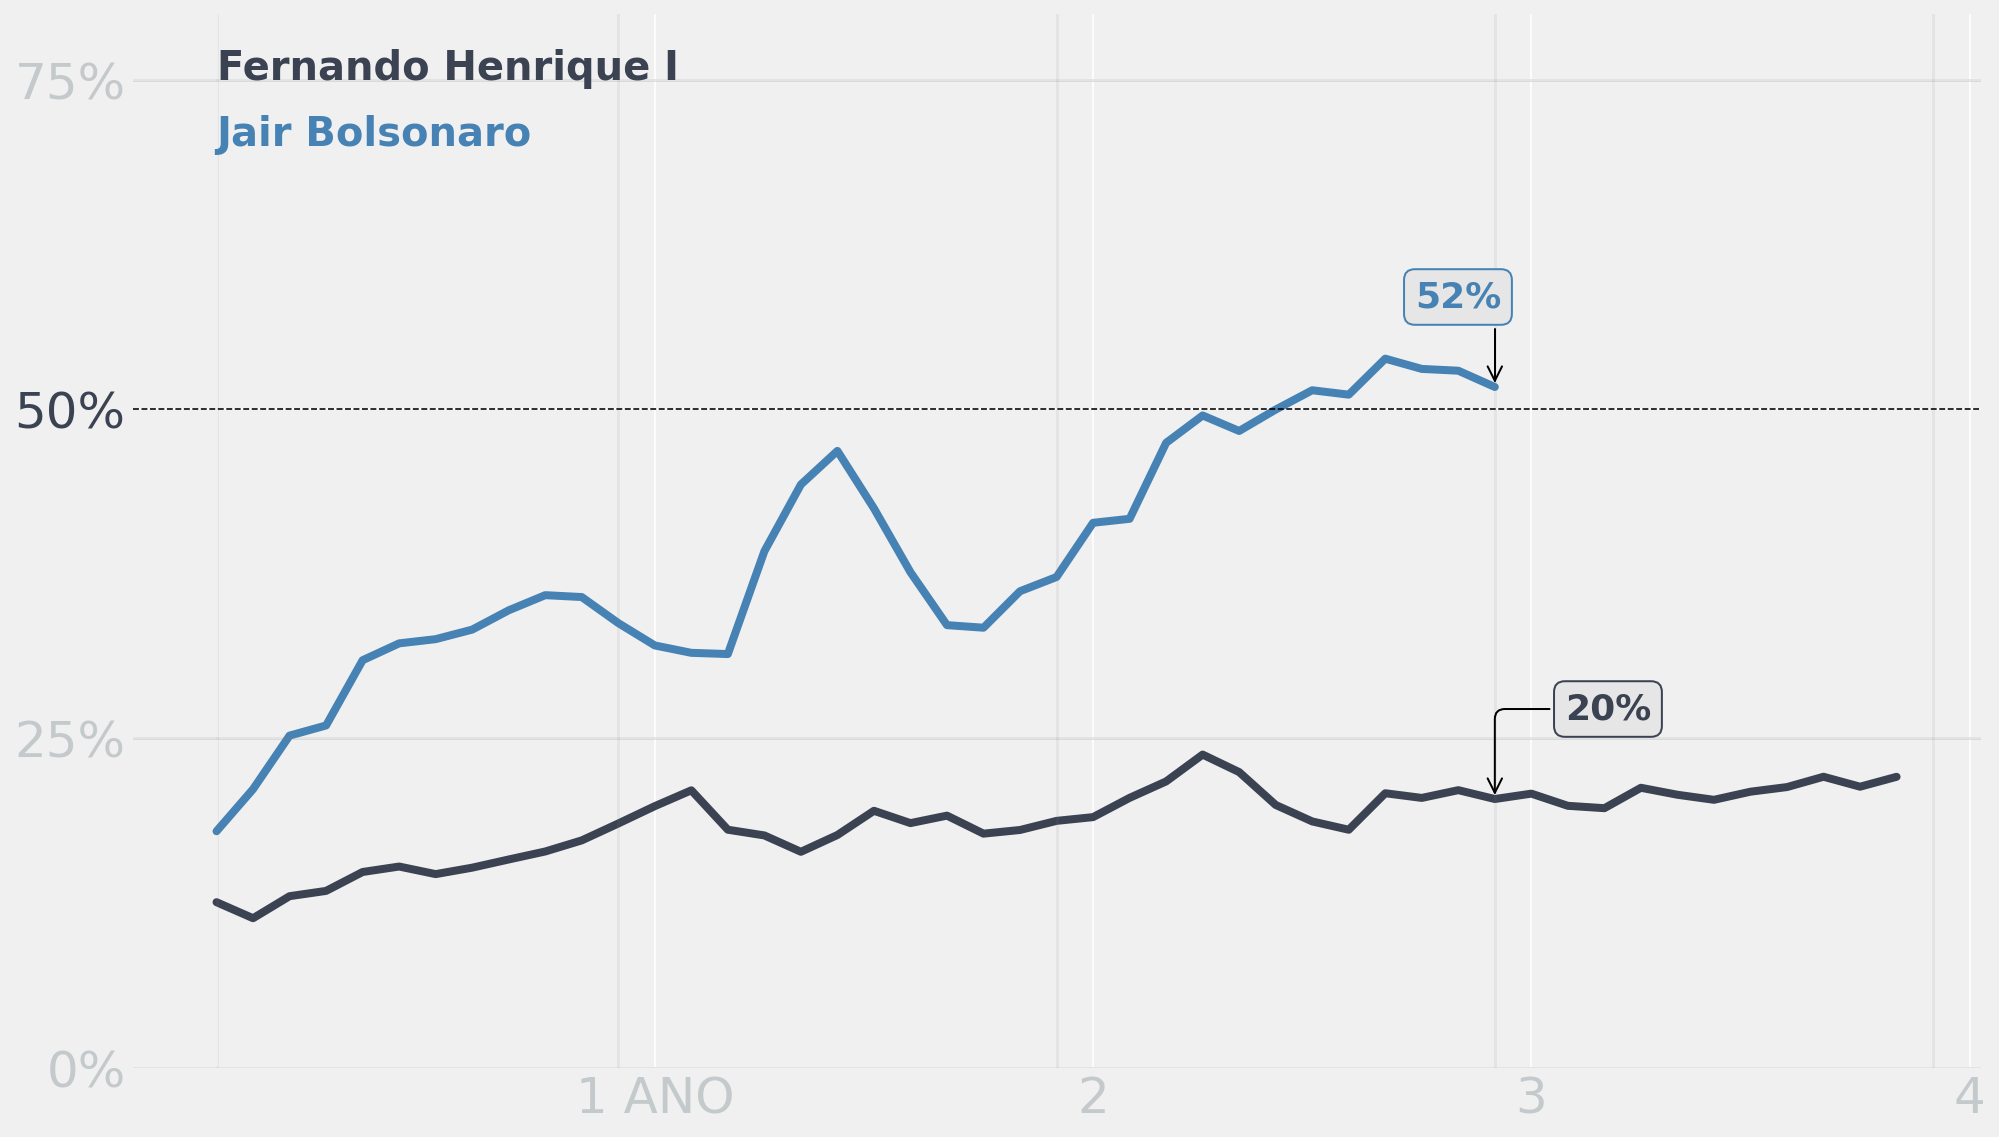

In [44]:
plot_static_curve("Fernando Henrique I")

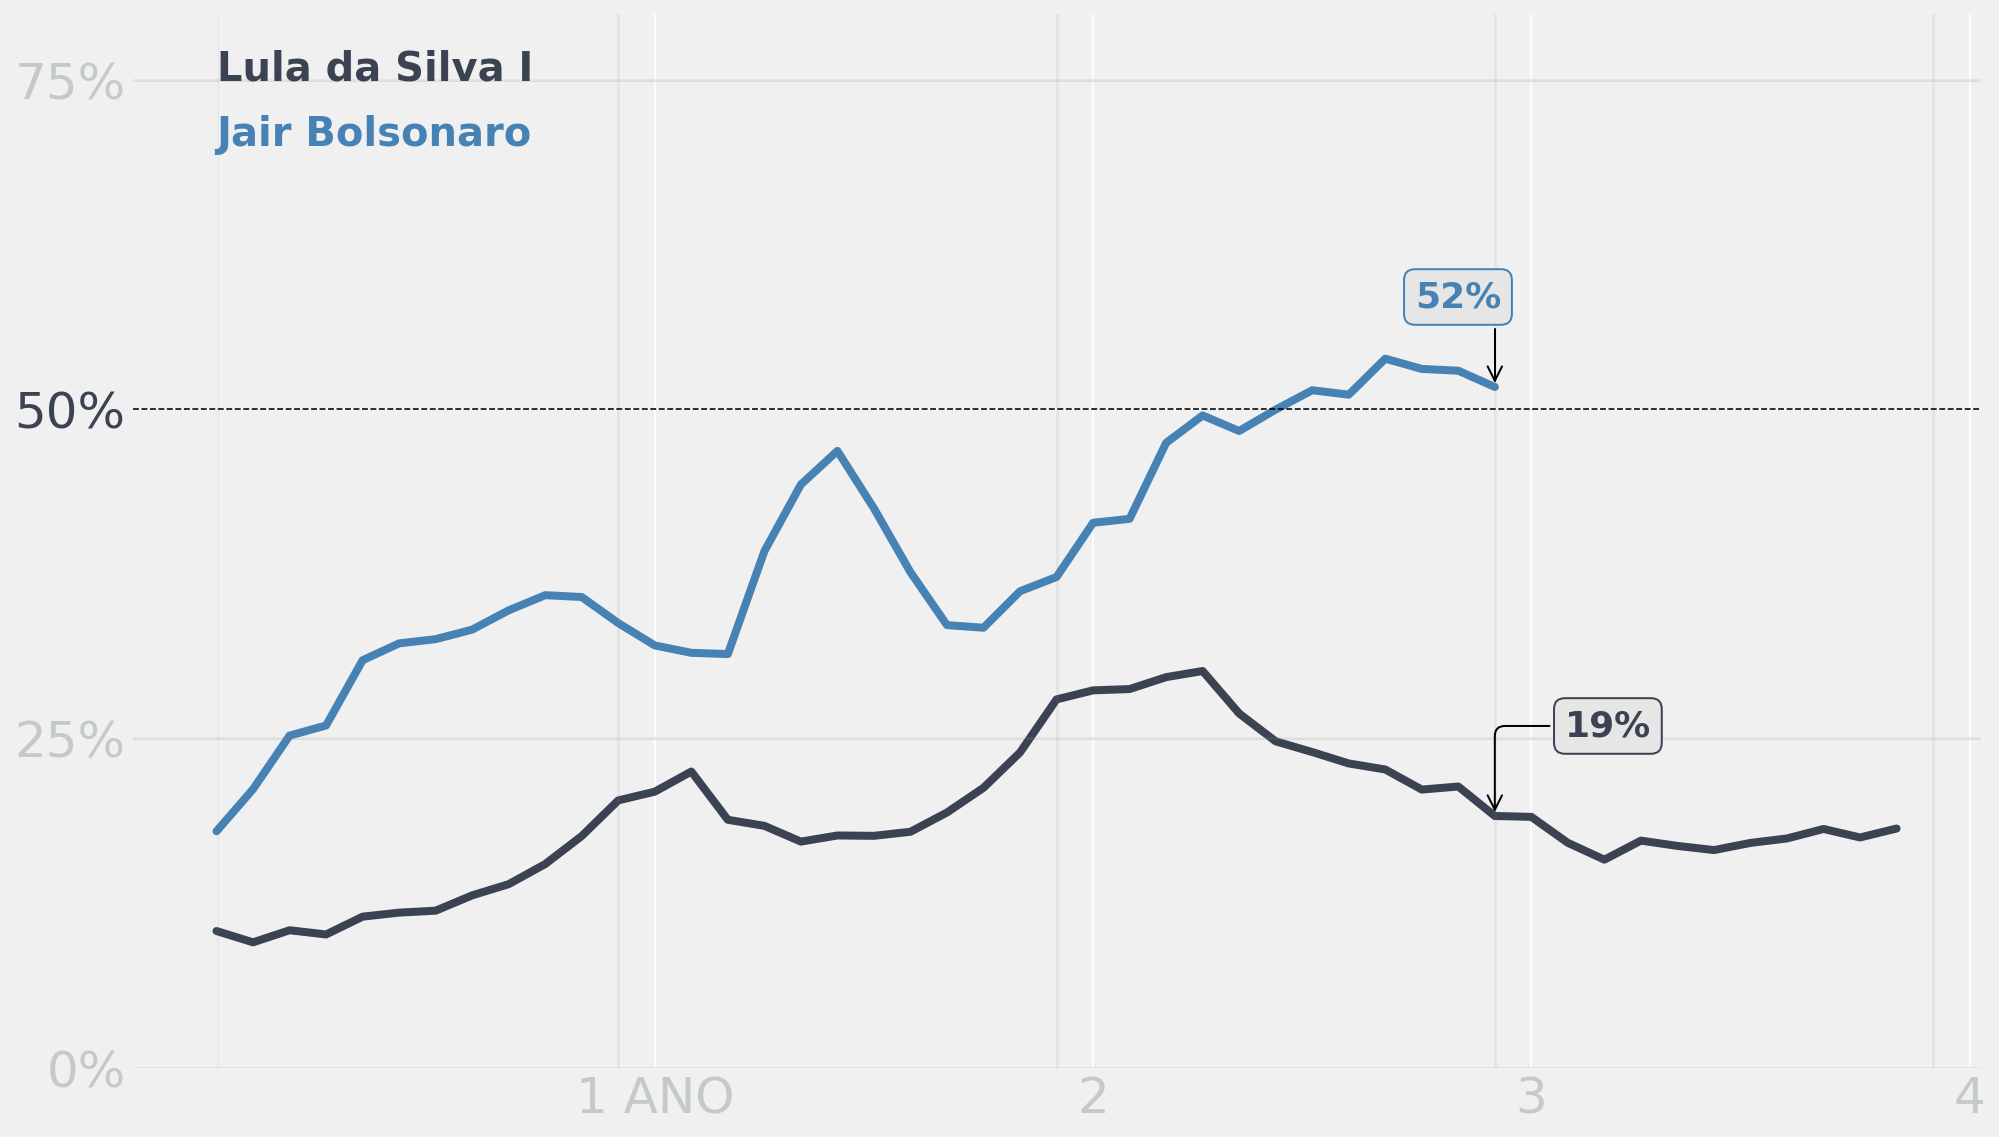

In [45]:
plot_static_curve("Lula da Silva I")

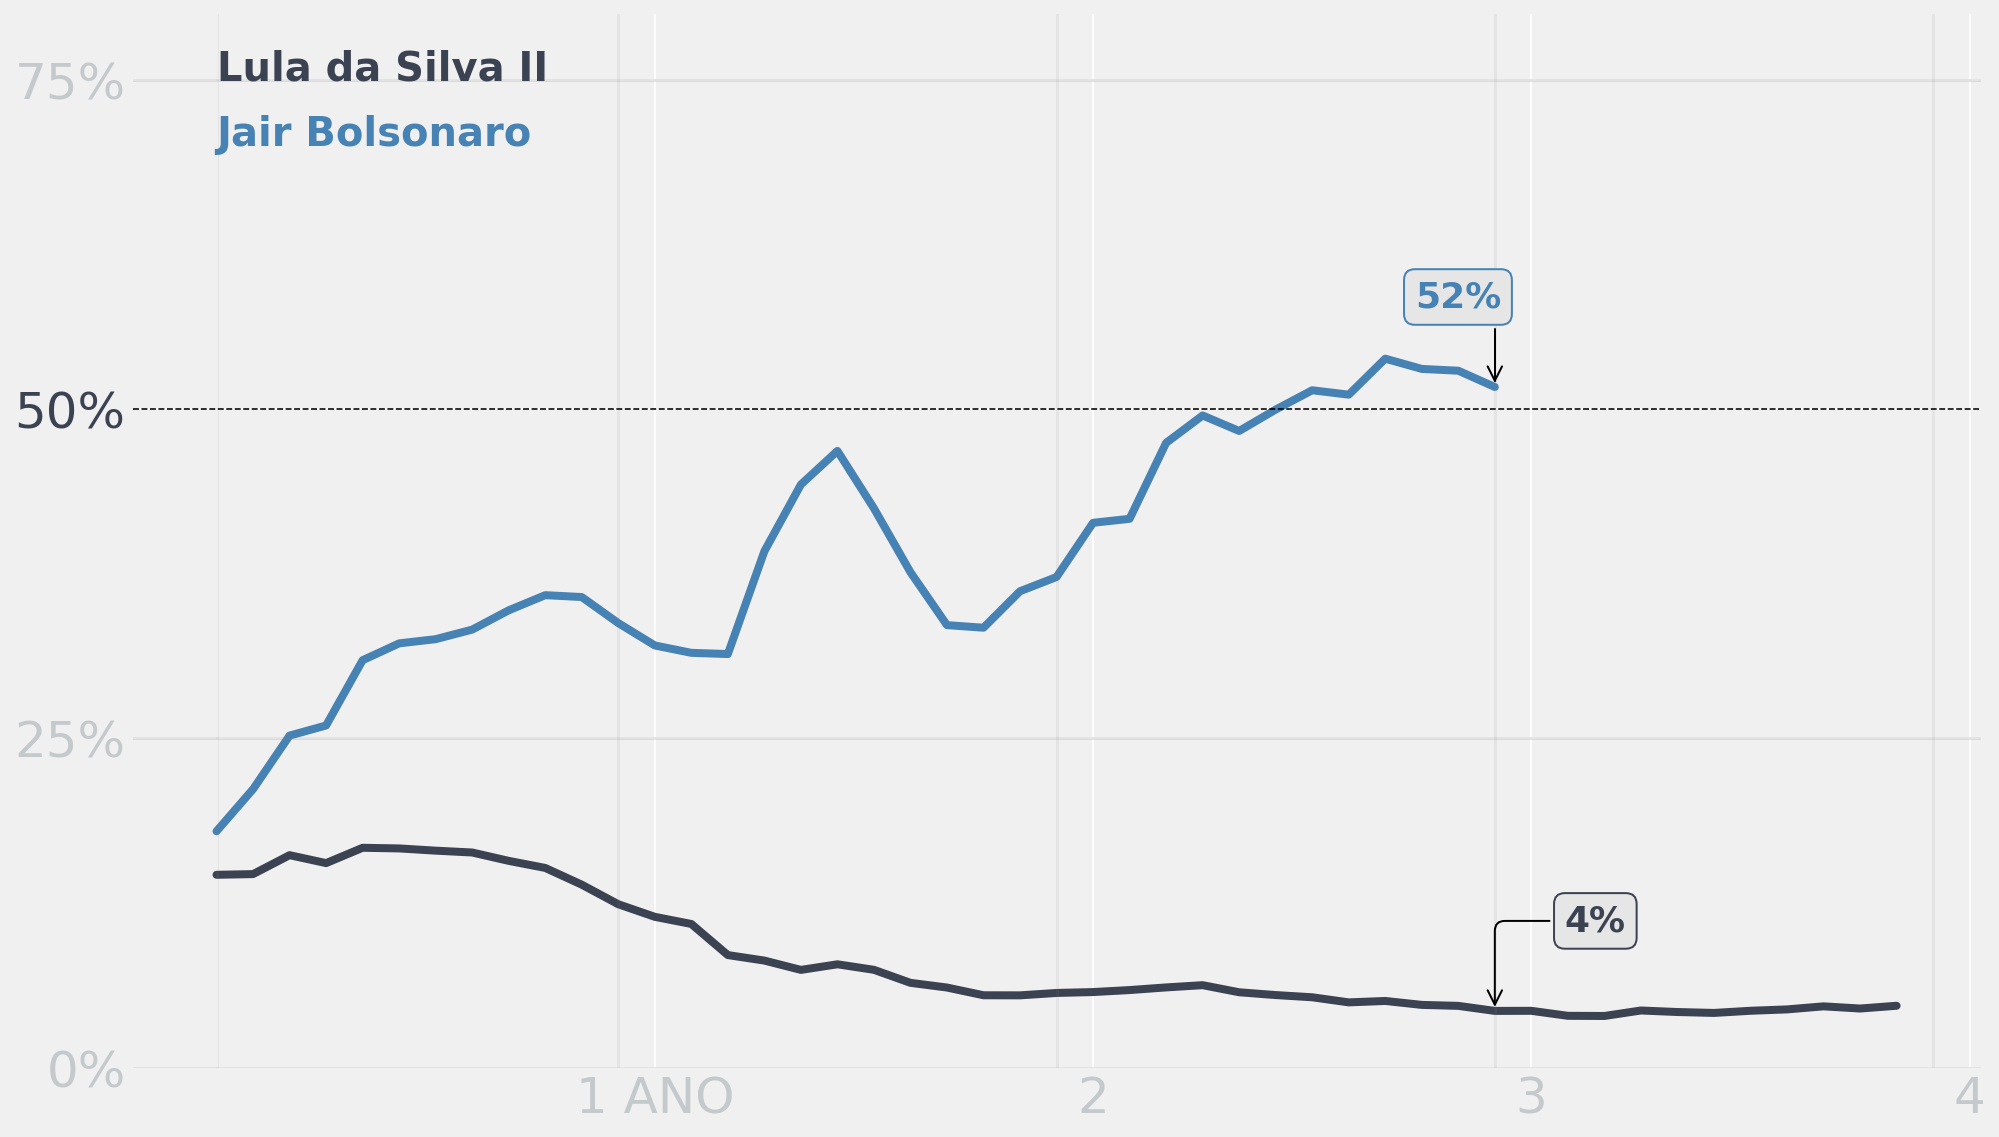

In [46]:
plot_static_curve("Lula da Silva II")

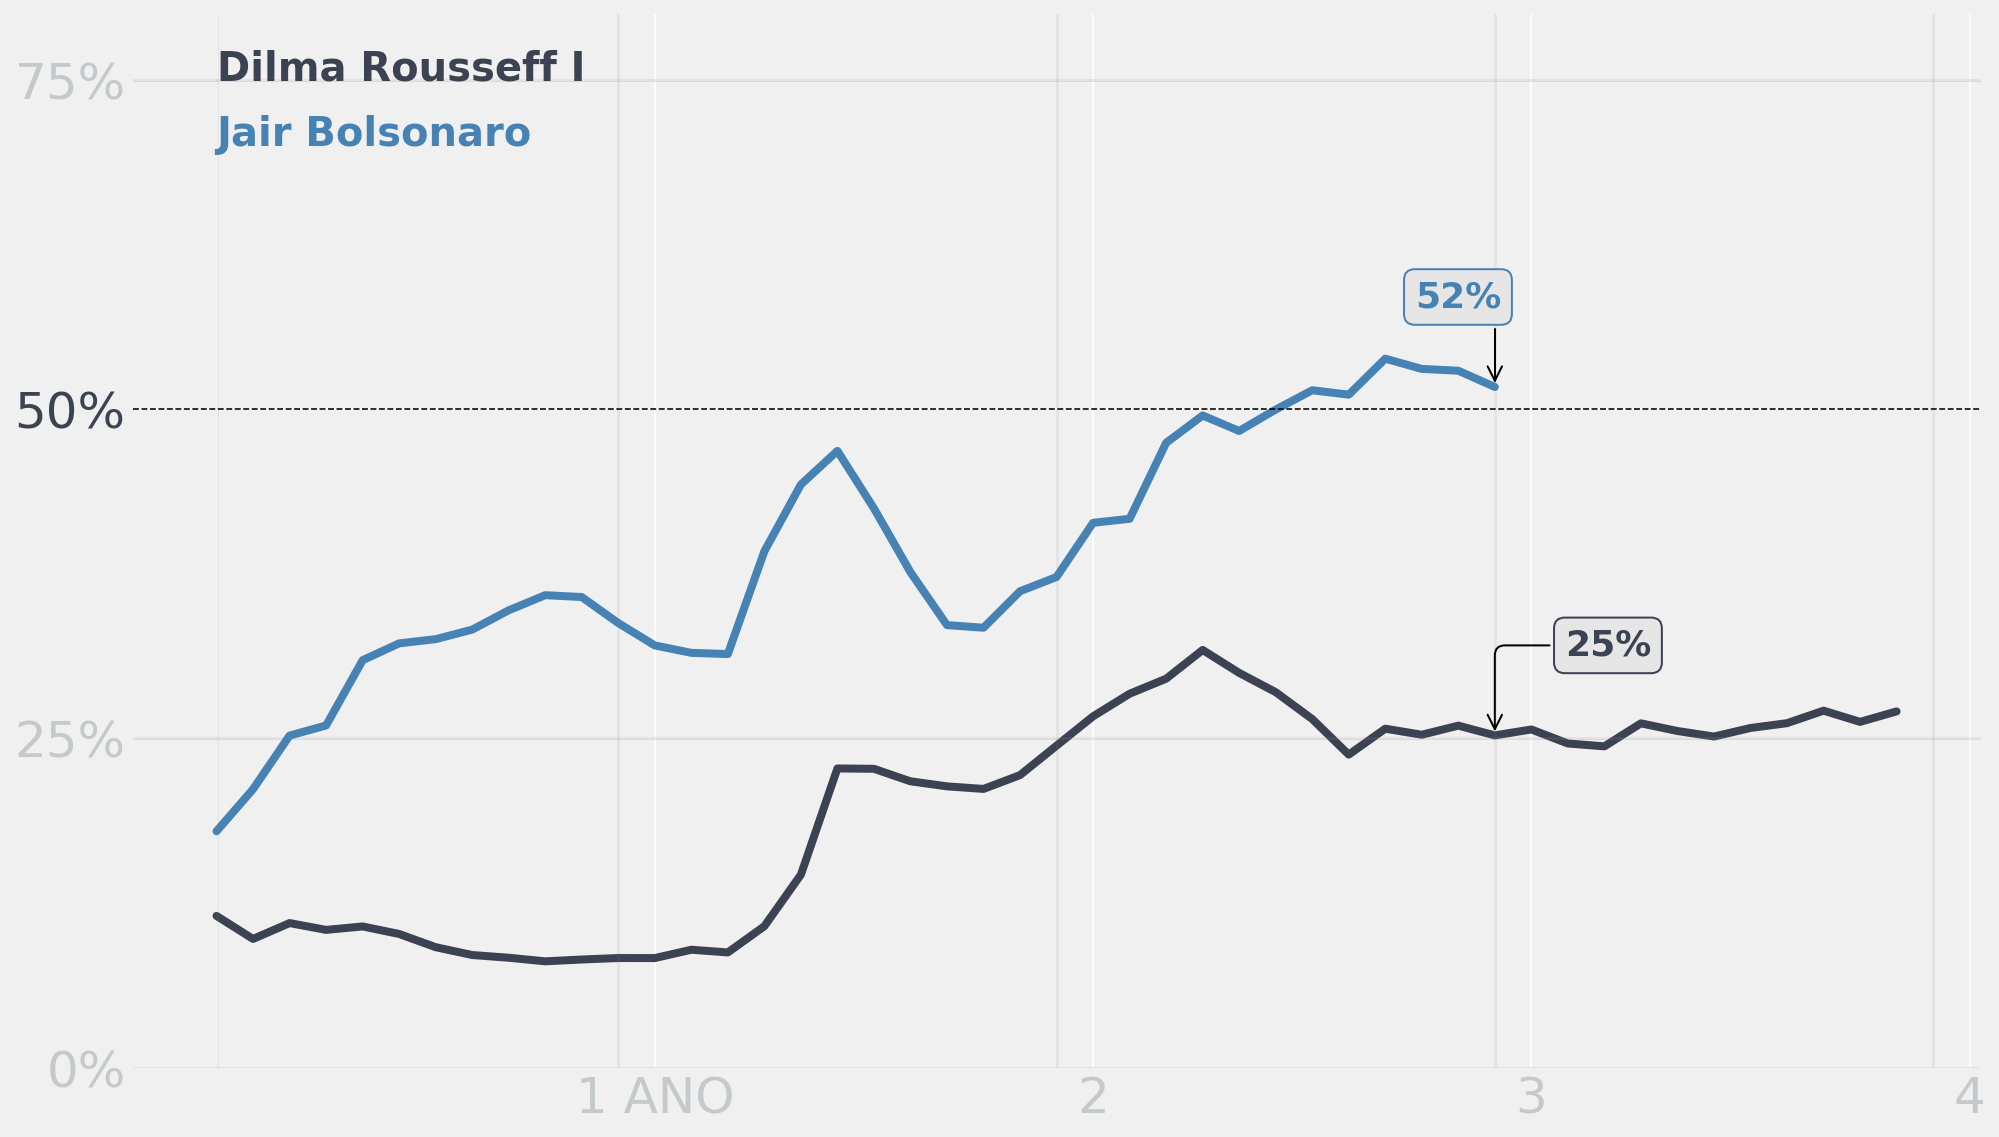

In [47]:
plot_static_curve("Dilma Rousseff I")

In [48]:
# plot_static_curve("Dilma Rousseff II")

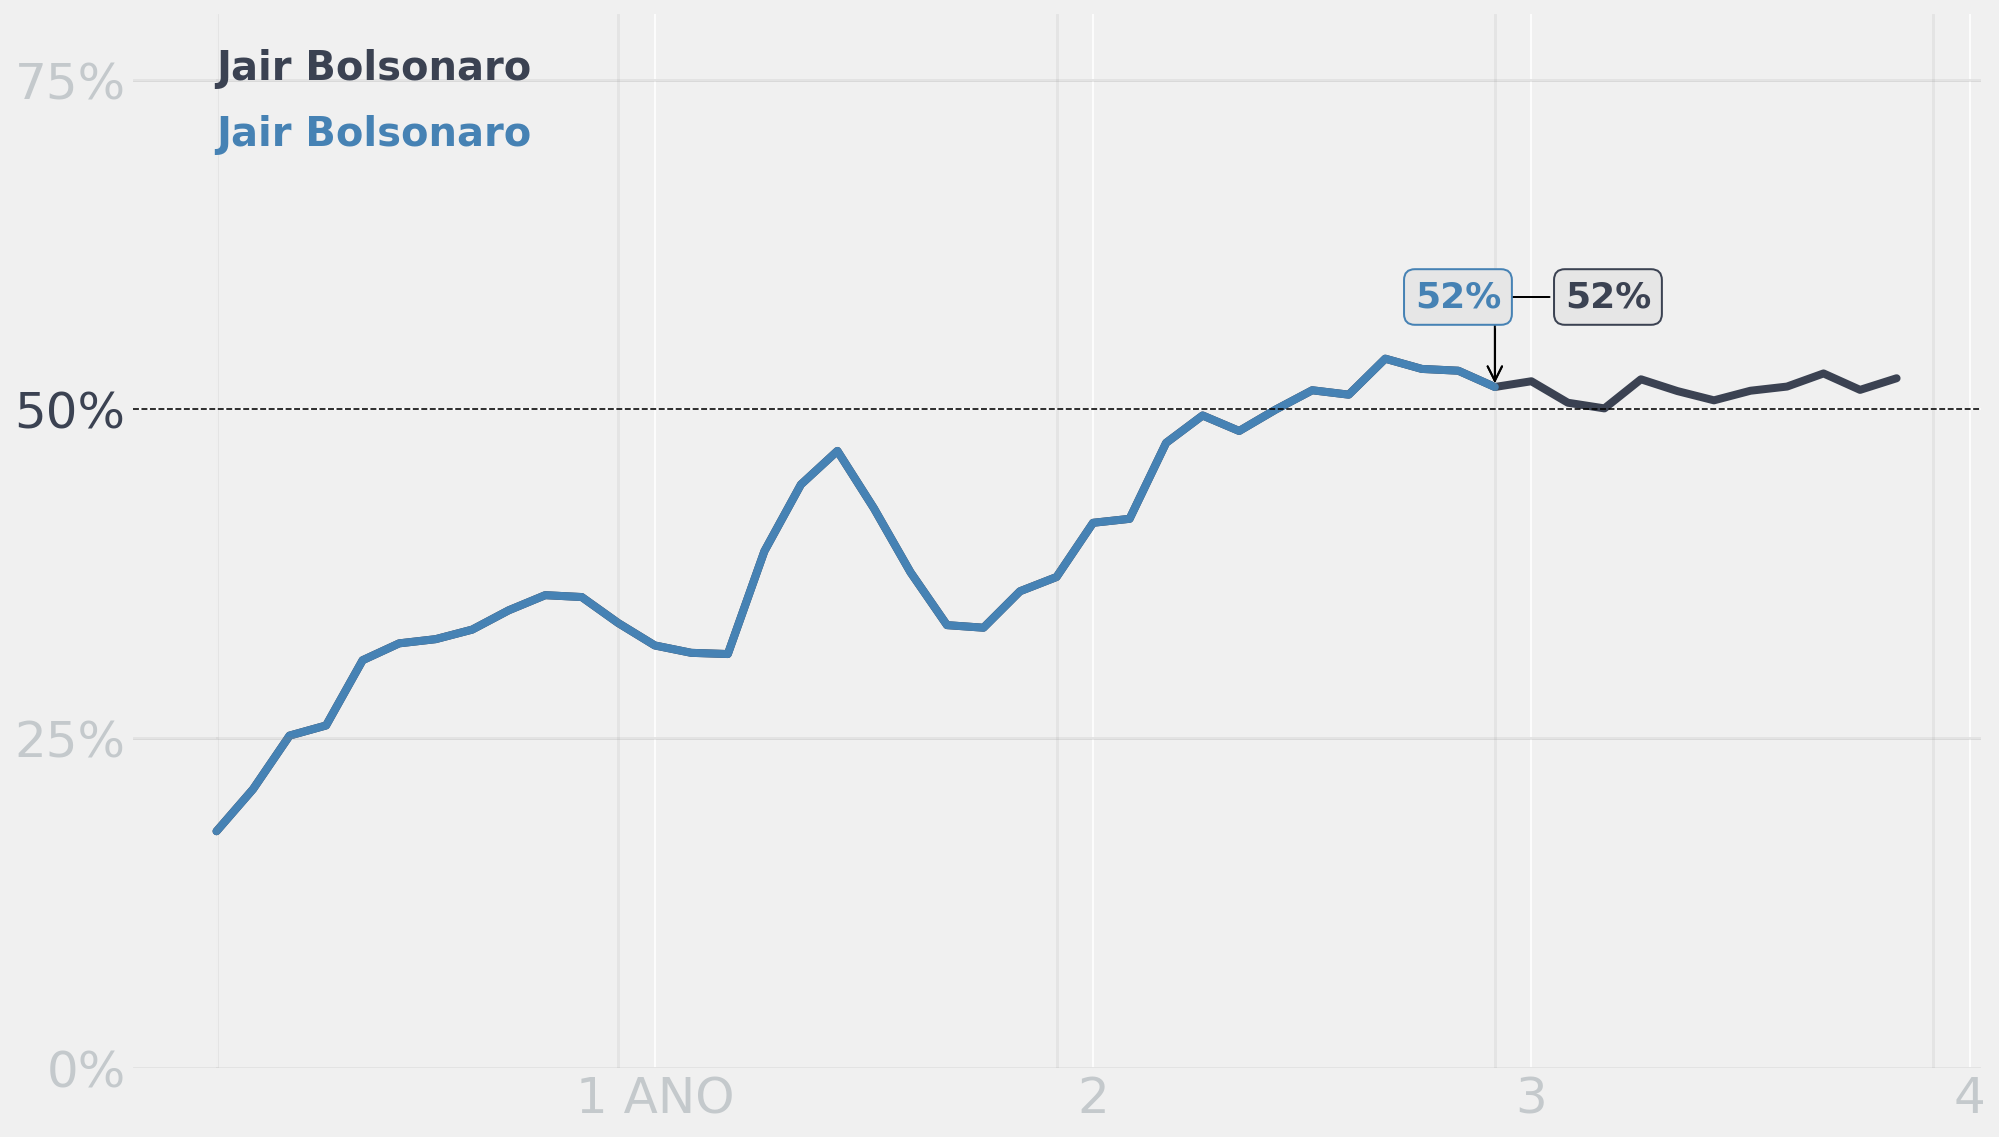

In [49]:
plot_static_curve("Jair Bolsonaro")

In [50]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Wed Nov 17 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.18.1

pandas    : 1.2.2
xarray    : 0.19.0
theano    : 1.1.2
pymc3     : 3.11.4
sqlite3   : 2.6.0
matplotlib: 3.3.4
csv       : 1.0
watermark : 2.2.0
numpy     : 1.20.1
datetime  : 4.3
arviz     : 0.11.2
sys       : 3.8.6 (default, Nov 20 2020, 18:29:40) 
[Clang 12.0.0 (clang-1200.0.32.27)]
seaborn   : 0.11.1

